# Sales Conversion Model New 20250527
### Excluding Self Gen & spliting the Buying power 

 ALL by ZIP: historical avg won amount by zip, avg/median buying power score(1st letter digit)
 ,avg/median household income by zip(adjantage of neighbo)
 ,avg/median of net asset value, avg/median of home value, avg/median of home improvement by zip

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import pandas as pd
import csv

from functools import reduce
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)

In [ ]:
files=[r'SCM_audience_data_new_v1_20250416.csv000']
correlation_path='V2_20250522/Correlation_Data_v1.xlsx'
backup_path_mts='V2_20250522/Input_data_full.csv'
model_pickle_mts='V2_20250522/RFE_file.pkl'
pred_out='V2_20250522/Pred_rfe.csv'
corr_cuttoff=0.7
sample_ratio=1.5

In [4]:
df = pd.read_csv(files[0],  delimiter='|',encoding='utf-8', on_bad_lines='warn', quoting=csv.QUOTE_NONE)

df.shape

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/3995215413.py:1: DtypeWarning: Columns (159,227) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(files[0],  delimiter='|',encoding='utf-8', on_bad_lines='warn', quoting=csv.QUOTE_NONE)


(479212, 295)

In [5]:
df.isna().sum()

address_1                                                                                            0
address_2                                                                                       479212
address                                                                                              0
addy_zip                                                                                             0
zip                                                                                                  0
backbone_id                                                                                          0
source_id                                                                                            0
source_name                                                                                          0
first_name                                                                                           4
last_name                                                                

In [6]:
df[df['buying_power_score'].isna()]['buying_power_score'].count()

0

In [7]:
df = df.astype({col: 'float32' for col in df.select_dtypes(include='float64').columns})
df = df.astype({col: 'float32' for col in df.select_dtypes(include='int64').columns})
df = df.astype({col: 'str' for col in df.select_dtypes(include='object').columns})

In [8]:
df.groupby('final_won_opp').size()

final_won_opp
0.0    385919
1.0     93293
dtype: int64


# EDA

In [9]:
print('\n',df['responsechannel'].value_counts())
print('\n',df['last_touch_channel'].value_counts())


 responsechannel
Web            273774
Call Center    128482
Call In         56831
Walk In         18731
                 1394
Name: count, dtype: int64

 last_touch_channel
Other                  138337
Pella.com              117326
SEM                     98717
PellaBranch.com         49669
Direct Mail             38599
Paid Social             11184
Direct Mail Nurture      9273
Nurture Email            4876
Television               3953
Returning Customer       3922
Showroom Event           2351
Radio                    1005
Name: count, dtype: int64


In [10]:
df[df['fiscalyear'] == 2022].groupby(['fiscalmonth'])['final_won_opp'].sum().reset_index().sort_values(by='final_won_opp', ascending=False)

,fiscalmonth,final_won_opp
7,MAR,2551.0
11,SEP,1794.0
6,JUN,1729.0
0,APR,1699.0
1,AUG,1473.0
8,MAY,1370.0
3,FEB,1362.0
5,JUL,1360.0
10,OCT,1219.0
4,JAN,1032.0


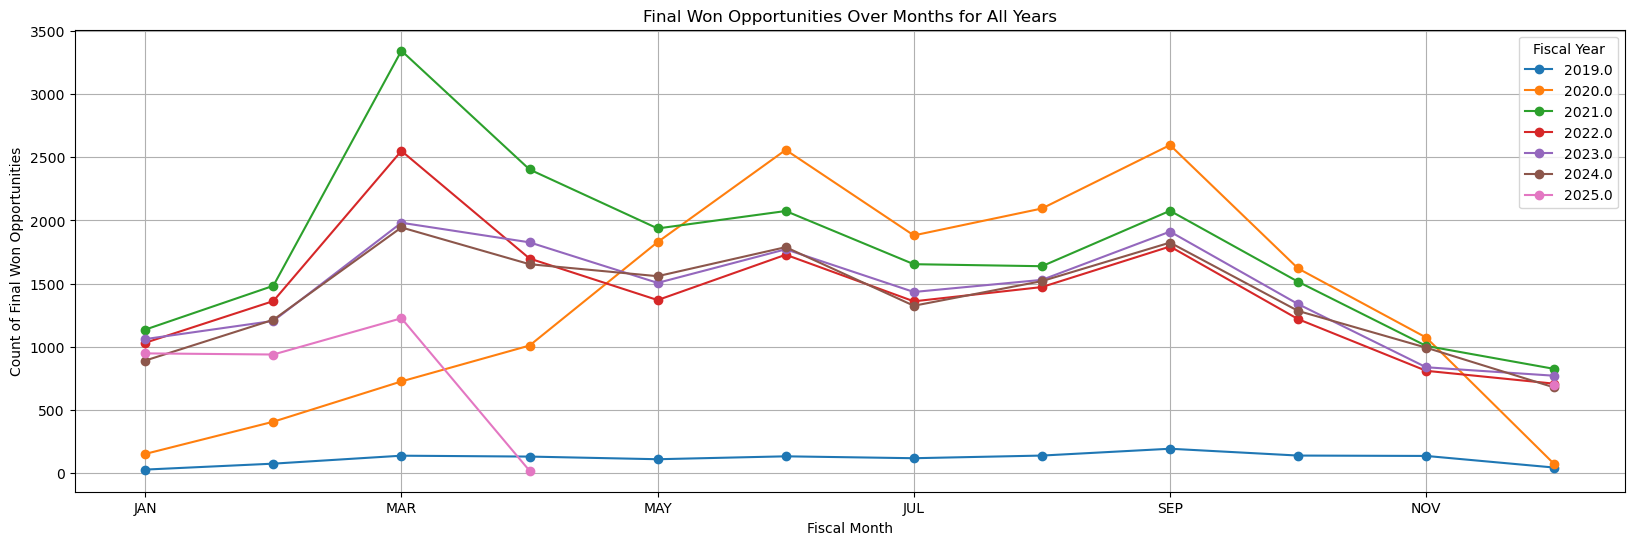

In [11]:
import matplotlib.pyplot as plt

# Define the correct order for fiscal months
month_order = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

# Filter data for final_won_opp = 1
won_data = df[df['final_won_opp'] == 1]

# Group by fiscalyear and fiscalmonth, and count occurrences
monthly_won = won_data.groupby(['fiscalyear', 'fiscalmonth']).size().reset_index(name='count')

# Convert fiscalmonth to categorical with the correct order
monthly_won['fiscalmonth'] = pd.Categorical(monthly_won['fiscalmonth'], categories=month_order, ordered=True)

# Sort the data by fiscalmonth
monthly_won = monthly_won.sort_values(by='fiscalmonth')

# Pivot the data to have fiscalmonth as x-axis and fiscalyear as separate lines
pivot_data = monthly_won.pivot(index='fiscalmonth', columns='fiscalyear', values='count')

# Plot the data
pivot_data.plot(kind='line', marker='o', figsize=(20, 6))
plt.title('Final Won Opportunities Over Months for All Years')
plt.xlabel('Fiscal Month')
plt.ylabel('Count of Final Won Opportunities')
plt.legend(title='Fiscal Year')
plt.grid(True)
plt.show()

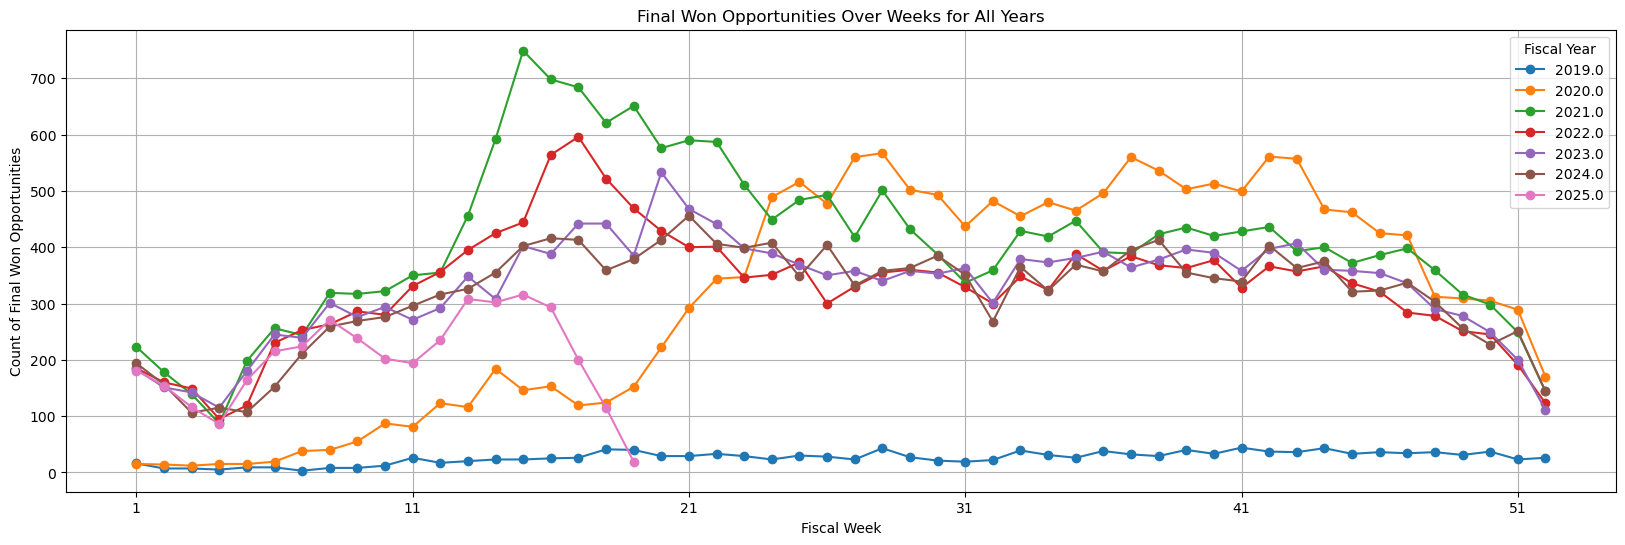

In [12]:
# Define the correct order for fiscal weeks (assuming 1 to 52)
week_order = list(range(1, 53))

# Filter data for final_won_opp = 1
won_data_week = df[df['final_won_opp'] == 1]

# Group by fiscalyear and fiscalweek, and count occurrences
weekly_won = won_data_week.groupby(['fiscalyear', 'fiscalweek']).size().reset_index(name='count')

# Ensure fiscalweek contains only valid values within the range 1 to 52
weekly_won = weekly_won[weekly_won['fiscalweek'].isin(week_order)]

# Convert fiscalweek to categorical with the correct order
weekly_won['fiscalweek'] = pd.Categorical(weekly_won['fiscalweek'], categories=week_order, ordered=True)

# Sort the data by fiscalweek
weekly_won = weekly_won.sort_values(by='fiscalweek')

# Pivot the data to have fiscalweek as x-axis and fiscalyear as separate lines
pivot_data_week = weekly_won.pivot(index='fiscalweek', columns='fiscalyear', values='count')

# Plot the data
pivot_data_week.plot(kind='line', marker='o', figsize=(20, 6))
plt.title('Final Won Opportunities Over Weeks for All Years')
plt.xlabel('Fiscal Week')
plt.ylabel('Count of Final Won Opportunities')
plt.legend(title='Fiscal Year')
plt.grid(True)
plt.show()

In [13]:
df[df['fiscalyear']==2019].groupby(['fiscalweek','final_won_opp']).size().reset_index(name='count')

,fiscalweek,final_won_opp,count
0,1.0,0.0,487
1,1.0,1.0,16
2,2.0,0.0,348
3,2.0,1.0,7
4,3.0,0.0,319
5,3.0,1.0,7
6,4.0,0.0,220
7,4.0,1.0,5
8,5.0,0.0,221
9,5.0,1.0,9


In [14]:
df[df['fiscalyear']==2019].groupby(['fiscalyear','fiscalweek'])['final_won_opp'].sum().reset_index().sort_values(by=['fiscalyear','fiscalweek'], ascending=True)  

,fiscalyear,fiscalweek,final_won_opp
0,2019.0,1.0,16.0
1,2019.0,2.0,7.0
2,2019.0,3.0,7.0
3,2019.0,4.0,5.0
4,2019.0,5.0,9.0
5,2019.0,6.0,9.0
6,2019.0,7.0,3.0
7,2019.0,8.0,8.0
8,2019.0,9.0,8.0
9,2019.0,10.0,12.0


In [15]:
pivot_data_week.to_clipboard()

In [16]:
df['fiscalweek'].unique()

array([48., 10., 20., 49., 11., 50., 51., 52., 12.,  1.,  2.,  3., 13.,
        4.,  5.,  6., 14.,  7.,  8., 15.,  9., 16., 19., 17., 18., 26.,
       21., 22., 23., 24., 25., 27., 28., 29., 30., 31., 32., 33., 34.,
       35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.,
       53.], dtype=float32)

In [17]:
# conversion rate by market
conversion_rate_by_market = (df[df['fiscalyear'] == 2024].groupby('market_gale')['final_won_opp'].sum() / 
							 df[df['fiscalyear'] == 2024].groupby('market_gale')['opps'].sum()).reset_index().rename(columns={0: 'conversion_rate'}).sort_values(by='conversion_rate', ascending=False)

conversion_rate_by_market

,market_gale,conversion_rate
25,748 - Omaha,0.416127
17,730 - Des Moines,0.388359
43,777 - Richmond,0.382753
23,743 - Northern Michigan,0.348101
22,743 - Grand Rapids,0.345443
16,728 - Indianapolis,0.324888
5,710 - Baltimore East,0.314159
42,775 - San Antonio,0.309859
49,789 - Minneapolis (Twin Cities Metro),0.309207
45,780 - Green Bay,0.304813


In [18]:
# conversion rate by market
conversion_rate_by_market = (df[df['fiscalyear'].isin([2021,2022,2023,2024])].groupby('market_gale')['final_won_opp'].sum() / 
							 df[df['fiscalyear'].isin([2021,2022,2023,2024])].groupby('market_gale')['opps'].sum()).reset_index().rename(columns={0: 'conversion_rate'}).sort_values(by='conversion_rate', ascending=False)

conversion_rate_by_market

,market_gale,conversion_rate
5,710 - Baltimore,1.000000
26,748 - Omaha,0.406904
18,730 - Des Moines,0.352270
6,710 - Baltimore East,0.337154
44,777 - Richmond,0.329164
23,743 - Grand Rapids,0.322156
17,728 - Indianapolis,0.311803
24,743 - Northern Michigan,0.305469
43,775 - San Antonio,0.303064
50,789 - Minneapolis (Twin Cities Metro),0.287435


In [19]:
df.dtypes

address_1                                                                                        object
address_2                                                                                       float32
address                                                                                          object
addy_zip                                                                                         object
zip                                                                                             float32
backbone_id                                                                                     float32
source_id                                                                                       float32
source_name                                                                                      object
first_name                                                                                       object
last_name                                                       

In [ ]:
region = pd.read_excel('/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_v2_20250522/Regions.xlsx')
df = df.merge(region, how='left', left_on='market_gale', right_on='Branch')
df.head()

In [21]:
df.drop(columns=['Branch'], inplace=True)

In [22]:
df['Region'].fillna('Others', inplace=True)

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/449229306.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Region'].fillna('Others', inplace=True)


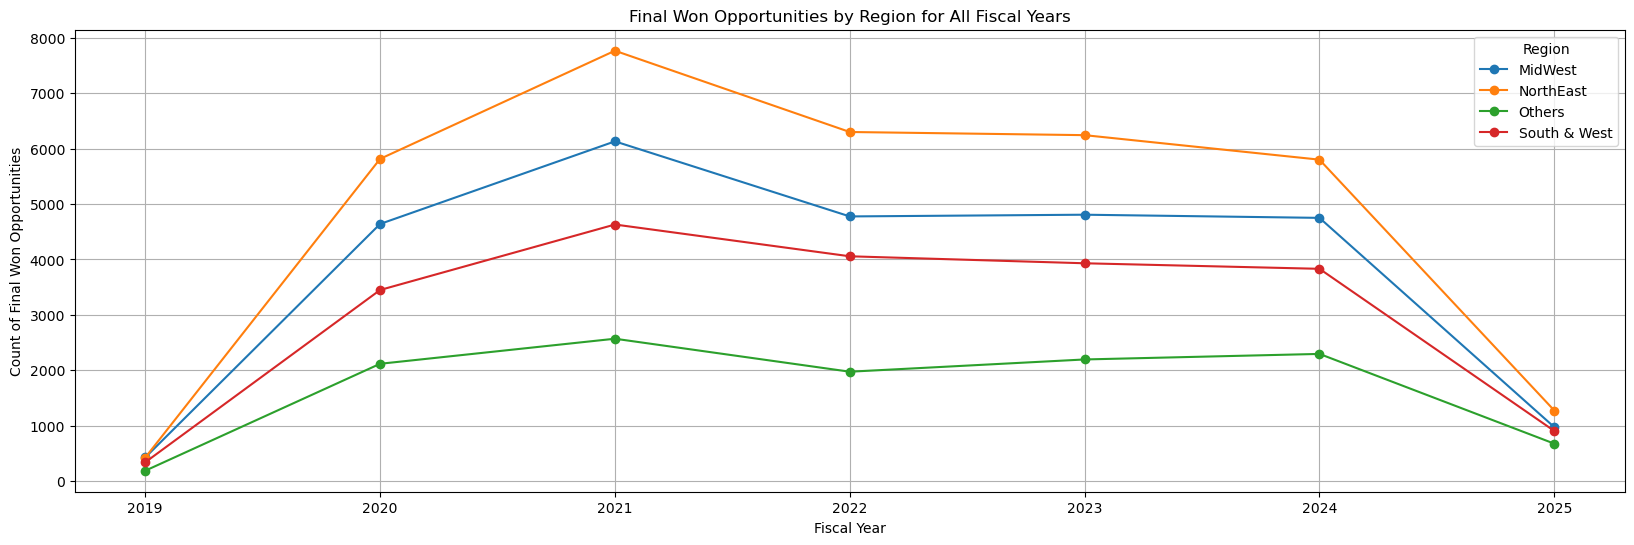

In [23]:
# Filter data for final_won_opp = 1
won_data_region = df[df['final_won_opp'] == 1]

# Group by Region and fiscalyear, and count occurrences
region_won = won_data_region.groupby(['Region', 'fiscalyear']).size().reset_index(name='count')

# Pivot the data to have fiscalyear as x-axis and Region as separate lines
pivot_region_data = region_won.pivot(index='fiscalyear', columns='Region', values='count')

# Plot the data
pivot_region_data.plot(kind='line', marker='o', figsize=(20, 6))
plt.title('Final Won Opportunities by Region for All Fiscal Years')
plt.xlabel('Fiscal Year')
plt.ylabel('Count of Final Won Opportunities')
plt.legend(title='Region')
plt.grid(True)
plt.show()

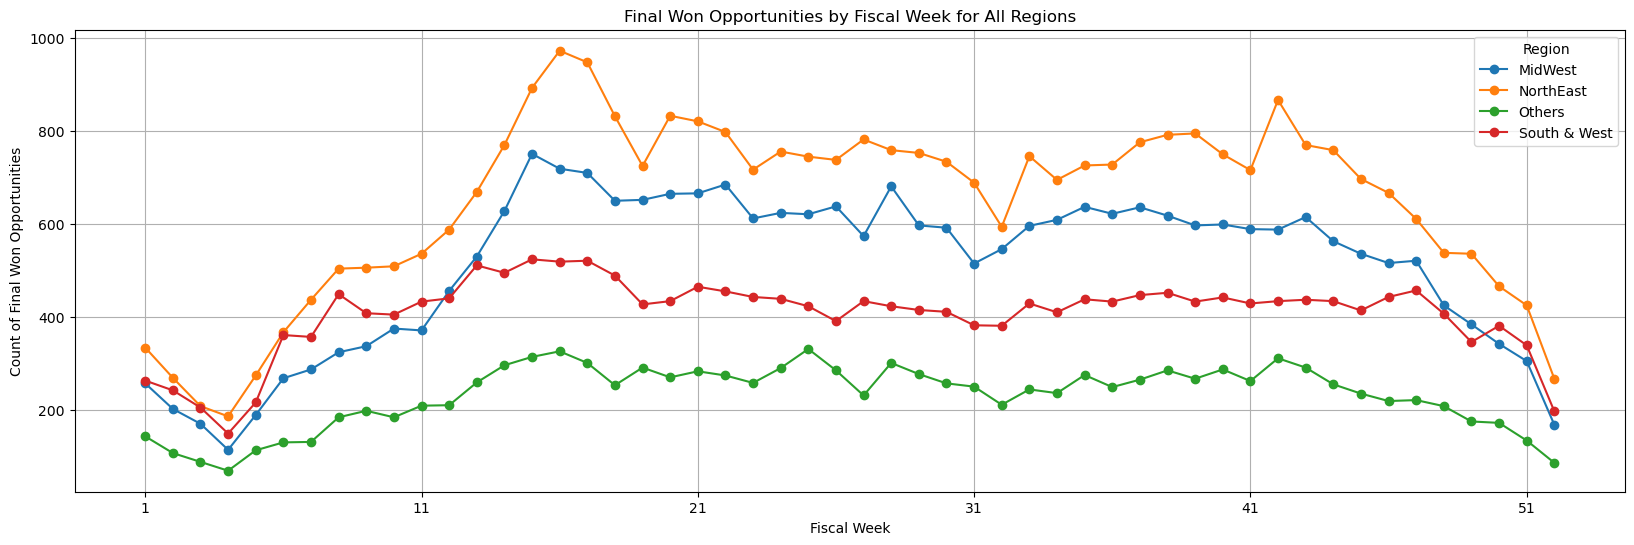

In [24]:
# Define the correct order for fiscal weeks (assuming 1 to 52)
week_order = list(range(1, 53))

# Filter data for final_won_opp = 1
won_data_week = df[df['final_won_opp'] == 1]

# Group by Region and fiscalweek, and count occurrences
weekly_region_won = won_data_week.groupby(['Region', 'fiscalweek']).size().reset_index(name='count')

# Ensure fiscalweek contains only valid values within the range 1 to 52
weekly_region_won = weekly_region_won[weekly_region_won['fiscalweek'].isin(week_order)]

# Convert fiscalweek to categorical with the correct order
weekly_region_won['fiscalweek'] = pd.Categorical(weekly_region_won['fiscalweek'], categories=week_order, ordered=True)

# Sort the data by fiscalweek
weekly_region_won = weekly_region_won.sort_values(by='fiscalweek')

# Pivot the data to have fiscalweek as x-axis and Region as separate lines
pivot_weekly_region_data = weekly_region_won.pivot(index='fiscalweek', columns='Region', values='count')

# Plot the data
pivot_weekly_region_data.plot(kind='line', marker='o', figsize=(20, 6))
plt.title('Final Won Opportunities by Fiscal Week for All Regions')
plt.xlabel('Fiscal Week')
plt.ylabel('Count of Final Won Opportunities')
plt.legend(title='Region')
plt.grid(True)
plt.show()

In [25]:
df[df['fiscalyear'] == 2024].groupby(['creation_time_of_day'])['final_won_opp'].sum().reset_index().sort_values(by='final_won_opp', ascending=False)

,creation_time_of_day,final_won_opp
0,Afternoon,7795.0
2,Morning,7304.0
1,Evening,1390.0
3,Night,188.0


In [26]:
df[df['fiscalyear'] == 2024].groupby(['creation_time_of_month'])['final_won_opp'].sum().reset_index().sort_values(by='final_won_opp', ascending=False)

,creation_time_of_month,final_won_opp
0,End_of_Month,5658.0
2,Mid_Month,5647.0
1,Initial_days_of_month,5372.0


In [27]:
df[df['fiscalyear'] == 2024].groupby(['appointment_time_of_day'])['final_won_opp'].sum().reset_index().sort_values(by='final_won_opp', ascending=False)

,appointment_time_of_day,final_won_opp
0,Afternoon,8671.0
2,Morning,7488.0
1,Evening,517.0
3,Night,1.0
4,nan,0.0


In [28]:
df[df['fiscalyear'] == 2024].groupby(['appointment_time_of_day'])['final_won_opp'].sum().reset_index().sort_values(by='final_won_opp', ascending=False)

,appointment_time_of_day,final_won_opp
0,Afternoon,8671.0
2,Morning,7488.0
1,Evening,517.0
3,Night,1.0
4,nan,0.0


In [29]:
df['creation_time_of_day'].value_counts()

creation_time_of_day
Morning      218683
Afternoon    193294
Evening       43383
Night         23852
Name: count, dtype: int64

# Feature Engineering

In [30]:
df.replace('nan',np.nan,inplace=True)

In [31]:
df.shape

(479212, 296)

In [32]:
print(df['marketing_tactic'].unique())

print(df['marketing_type'].unique())

['Untraceable' 'Digital' nan 'Direct Mail' 'Other' 'Nurture' 'Print'
 'Broadcast' 'Event' 'Signage' 'Canvassing' 'Referral' 'Sponsorship']
['Untraceable' 'Digital' nan 'Direct Mail' 'Other' 'Nurture' 'Print'
 'Referral' 'Broadcast' 'Event' 'Signage' 'Canvassing' 'Email' 'List'
 'Sponsorship' 'Advertisement']


In [34]:
df.isna().sum()

address_1                                                                                            0
address_2                                                                                       479212
address                                                                                              0
addy_zip                                                                                             0
zip                                                                                                  0
backbone_id                                                                                          0
source_id                                                                                            0
source_name                                                                                          0
first_name                                                                                           4
last_name                                                                

In [35]:
df.dtypes

address_1                                                                                        object
address_2                                                                                       float32
address                                                                                          object
addy_zip                                                                                         object
zip                                                                                             float32
backbone_id                                                                                     float32
source_id                                                                                       float32
source_name                                                                                      object
first_name                                                                                       object
last_name                                                       

In [36]:
df.isna().sum()

address_1                                                                                            0
address_2                                                                                       479212
address                                                                                              0
addy_zip                                                                                             0
zip                                                                                                  0
backbone_id                                                                                          0
source_id                                                                                            0
source_name                                                                                          0
first_name                                                                                           4
last_name                                                                

In [37]:
df['estimated_current_home_value'].unique()

array([ 597400., 2877400., 1332000., ..., 2474700., 3142000., 4538000.],
      dtype=float32)

In [38]:
df['property_realty_home_improvement_value'].unique()

array([   0.,  667.,  648., ..., 3389., 6395., 2740.], dtype=float32)

In [39]:
df['buying_power_score'].unique() # take indivduals


array(['1A', '3A', '3C', '5C', '1B', '2A', '5B', '2C', '2B', '2D', '4A',
       nan, '3B', '5A', '6A', '4B', '5D', '7B', '9D', '4C', '1C', '6C',
       '7C', '6B', '3D', '8B', '8D', '6D', '8A', '4D', '9C', '7D', '8C',
       '7A', '9B', '1D'], dtype=object)

In [40]:
df['net_asset_value'].unique() # take indivduals

array(['H', 'G', 'C', 'I', 'F', 'J', 'A', 'E', 'B', 'D', nan],
      dtype=object)

In [41]:
df['estimated_current_home_value'].unique() # take indivduals

array([ 597400., 2877400., 1332000., ..., 2474700., 3142000., 4538000.],
      dtype=float32)

In [42]:
df['religion'].unique() # take indivduals

array([nan, 'C', 'P', 'O', 'J', 'I', 'B', 'G', 'H', 'S', 'K', 'L', 'E'],
      dtype=object)

In [43]:
df['ethnic_group'].unique() # take indivduals

array([nan, 'L', 'K', 'A', 'I', 'O', 'N', 'J', 'F', 'E', 'C', 'B'],
      dtype=object)

In [44]:
df['vacancy_indicator'].unique() # take indivduals

array(['N', 'Y', nan], dtype=object)

In [45]:
df['dwelling_type'].unique() # take indivduals

array(['S', 'M', 'A', nan], dtype=object)

In [46]:
df['dwelling_type'].isna().sum()

901

In [47]:
df.replace('nan', np.nan, inplace=True)

In [48]:
df['ethnic_group'].unique() # take indivduals

array([nan, 'L', 'K', 'A', 'I', 'O', 'N', 'J', 'F', 'E', 'C', 'B'],
      dtype=object)

In [49]:
df['religion'].unique() # take indivduals

array([nan, 'C', 'P', 'O', 'J', 'I', 'B', 'G', 'H', 'S', 'K', 'L', 'E'],
      dtype=object)

In [50]:
df['vacancy_indicator'].unique() # take indivduals
df['dwelling_unit_size'].unique() # take indivduals

array(['A', 'B', 'E', 'C', nan, 'D', 'G', 'I', 'F', 'H'], dtype=object)

In [51]:
import holidays
def is_near_holiday(date):
    return any((date + pd.Timedelta(days=offset)) in us_holidays for offset in range(-2, 3))

us_holidays = holidays.UnitedStates()
df['creationdt_is_holiday'] = pd.to_datetime(df['creationdt_local_time']).apply(lambda x: 1 if is_near_holiday(x.date()) else 0)

df['creationdt_is_holiday'].value_counts()

creationdt_is_holiday
0    423010
1     56202
Name: count, dtype: int64

In [52]:
result = df.groupby(['final_won_opp', 'creationdt_is_holiday']).size().reset_index(name='count')
result['percentage'] = (result['count'] / result['count'].sum()) * 100
result = result.sort_values(by='count', ascending=False)
result

,final_won_opp,creationdt_is_holiday,count,percentage
0,0.0,0,340726,71.101308
2,1.0,0,82284,17.170689
1,0.0,1,45193,9.430690
3,1.0,1,11009,2.297313


In [53]:
# import holidays
# def is_near_holiday(date):
#     return any((date + pd.Timedelta(days=offset)) in us_holidays for offset in range(-2, 3))

# us_holidays = holidays.UnitedStates()
# df['appointmentdt_is_holiday'] = pd.to_datetime(df['appointmentdt_local_time']).apply(lambda x: 1 if is_near_holiday(x.date()) else 0)

# print(df['appointmentdt_is_holiday'].value_counts())
# df.groupby(['final_won_opp', 'appointmentdt_is_holiday']).size().reset_index(name='count').sort_values(by='count', ascending=False)
# result = df.groupby(['final_won_opp', 'appointmentdt_is_holiday']).size().reset_index(name='count')
# result['percentage'] = (result['count'] / result['count'].sum()) * 100
# result = result.sort_values(by='count', ascending=False)
# result

### Value Encoding dictionary

In [54]:
# Value Encoding dictionary
# df['vacancy_indicator_1']=df['vacancy_indicator'].map({'Y':1,'N':0}).astype('float32')

# Value Encoding dictionary
df['vacancy_indicator_1']=df['vacancy_indicator'].map({'Y':1,'N':0}).astype('float32') 

df['dwelling_unit_size_1']=df['dwelling_unit_size'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':10,'G':20,'H':50,'I':101}).astype('float32')
 
df.drop(['vacancy_indicator','dwelling_unit_size'],axis=1,inplace=True)
df.rename(columns={
                   'vacancy_indicator_1':'vacancy_indicator' , 'dwelling_unit_size_1':'dwelling_unit_size'
                   },inplace=True)

In [55]:
df['vacancy_indicator'].unique()

array([ 0.,  1., nan], dtype=float32)

### Split Buying Power Score

In [56]:
df['disposable_part_of_bps'] = np.where(
    df['buying_power_score'].isna(),
    np.nan,
    df['buying_power_score'].astype(str).str[0]
)

df['ability_part_of_bps'] = np.where(
    df['buying_power_score'].isna(),
    np.nan,
    df['buying_power_score'].astype(str).str[-1]
)

print(df['disposable_part_of_bps'].unique())
print(df['ability_part_of_bps'].unique())

['1' '3' '5' '2' '4' nan '6' '7' '9' '8']
['A' 'C' 'B' 'D' nan]


In [57]:
# df['disposable_part_of_bps'] = np.where(
#     df['buying_power_score'].isna(),
#     np.nan,
#     df['disposable_part_of_bps'].map({'9':'1','8':'2','7':'3','6':'4','5':'5','4':'6','3':'7','2':'8','1':'9'})
# )


# df['ability_part_of_bps'] = np.where(
#     df['buying_power_score'].isna(),
#     np.nan,
#     df['ability_part_of_bps'].map({'D':'1','C':'2','B':'3','A':'4'})
# )

# print(df['disposable_part_of_bps'].unique())
# print(df['ability_part_of_bps'].unique())

In [58]:
df['disposable_part_of_bps'].unique()

array(['1', '3', '5', '2', '4', nan, '6', '7', '9', '8'], dtype=object)

In [59]:
df['disposable_part_of_bps'] = df['disposable_part_of_bps'].astype('float32')
df['disposable_part_of_bps'].unique()

array([ 1.,  3.,  5.,  2.,  4., nan,  6.,  7.,  9.,  8.], dtype=float32)

In [60]:
agg_zip_df = pd.DataFrame(df['zip'].unique(), columns=['zip'])

# Avg Won Amount by Zip
agg_zip_df = pd.merge(agg_zip_df, df.groupby(['zip'])['won_amount'].aggregate('mean').reset_index().rename(columns={'won_amount': 'avg_zip_won_amount'}), on='zip', how='left')
# agg_zip_df = pd.merge(agg_zip_df, df.groupby(['zip'])['households_median_income'].aggregate('mean').reset_index().rename(columns={'households_median_income': 'avg_zip_households_median_income'}), on='zip', how='left')
# agg_zip_df = pd.merge(agg_zip_df, df.groupby(['zip'])['estimated_current_home_value'].aggregate('mean').reset_index().rename(columns={'estimated_current_home_value': 'avg_zip_estimated_current_home_value'}), on='zip', how='left')
# agg_zip_df = pd.merge(agg_zip_df, df.groupby(['zip'])['property_realty_home_improvement_value'].aggregate('mean').reset_index().rename(columns={'property_realty_home_improvement_value': 'avg_zip_property_realty_home_improvement_value'}), on='zip', how='left')
# agg_zip_df = pd.merge(agg_zip_df, df.groupby(['zip'])['disposable_part_of_bps'].aggregate('mean').reset_index().rename(columns={'disposable_part_of_bps': 'avg_zip_disposable_part_of_bps'}), on='zip', how='left')
agg_zip_df


df = pd.merge(df, agg_zip_df, on='zip', how='left')

In [61]:
df['net_asset_value'].unique()

array(['H', 'G', 'C', 'I', 'F', 'J', 'A', 'E', 'B', 'D', nan],
      dtype=object)

In [62]:
median_zip_df = pd.DataFrame(df['zip'].unique(), columns=['zip'])
median_zip_df = pd.merge(median_zip_df, df.groupby('zip')['households_median_income'].median().reset_index().rename(columns={'households_median_income': 'zip_median_households_median_income'}), on='zip', how = 'left')
median_zip_df = pd.merge(median_zip_df, df.groupby('zip')['estimated_current_home_value'].median().reset_index().rename(columns={'estimated_current_home_value': 'zip_median_estimated_current_home_value'}), on='zip', how = 'left')
median_zip_df = pd.merge(median_zip_df, df.groupby('zip')['property_realty_home_improvement_value'].median().reset_index().rename(columns={'property_realty_home_improvement_value': 'zip_median_property_realty_home_improvement_value'}), on='zip', how = 'left')
median_zip_df = pd.merge(median_zip_df, df.groupby('zip')['disposable_part_of_bps'].median().reset_index().rename(columns={'disposable_part_of_bps': 'zip_median_disposable_part_of_bps'}), on='zip', how = 'left')
median_zip_df = pd.merge(median_zip_df, df.groupby('zip')['est_household_income'].median().reset_index().rename(columns={'est_household_income': 'zip_median_est_household_income'}), on='zip', how = 'left')
# median_zip_df = pd.merge(median_zip_df, df.groupby('zip')['net_asset_value'].median().reset_index().rename(columns={'net_asset_value': 'zip_median_net_asset_value'}), on='zip', how = 'left')
median_zip_df#'households_median_income','estimated_current_home_value','property_realty_home_improvement_value','disposable_part_of_bps','estimated_household_income','net_asset_value'

,zip,zip_median_households_median_income,zip_median_estimated_current_home_value,zip_median_property_realty_home_improvement_value,zip_median_disposable_part_of_bps,zip_median_est_household_income
0,32803.0,87635.0,571200.0,0.0,3.0,140.0
1,91604.0,124271.0,2233300.0,334.5,1.0,250.0
2,2130.0,106153.0,1293400.0,670.0,2.0,175.0
3,48083.0,80222.0,404000.0,0.0,3.0,160.0
4,49525.0,80841.0,392200.0,0.0,2.0,190.0
...,...,...,...,...,...,...
11360,73096.0,53846.0,346000.0,35.0,2.0,170.0
11361,33936.0,41634.0,203300.0,155.0,7.0,20.0
11362,30525.0,46224.0,248000.0,66.0,3.0,250.0
11363,55962.0,59063.0,649000.0,255.0,2.0,250.0


In [63]:
df = pd.merge(df, median_zip_df, on='zip', how='left')

In [64]:
df[['zip','zip_median_households_median_income','zip_median_estimated_current_home_value','zip_median_property_realty_home_improvement_value','zip_median_disposable_part_of_bps','zip_median_est_household_income']].isna().sum()

zip                                                     0
zip_median_households_median_income                  1075
zip_median_estimated_current_home_value              9591
zip_median_property_realty_home_improvement_value       5
zip_median_disposable_part_of_bps                      64
zip_median_est_household_income                         5
dtype: int64

In [65]:
print(df[df['zip_median_households_median_income'].isna()]['zip'].nunique())
print(df[df['zip_median_estimated_current_home_value'].isna()]['zip'].nunique())
print(df[df['zip_median_property_realty_home_improvement_value'].isna()]['zip'].nunique())

40
566
4


In [66]:
df[df['zip']==45681]['estimated_current_home_value'].unique()

array([nan], dtype=float32)

In [67]:
# columns_to_check = ['zip_median_households_median_income', 
#                     'zip_median_estimated_current_home_value', 
#                     'zip_median_property_realty_home_improvement_value', 
#                     'zip_median_disposable_part_of_bps'
#                     ,'zip_median_est_household_income']

# null_zips = {col: df[df[col].isna()]['zip'].nunique() for col in columns_to_check}
# null_zips

In [68]:
import holidays
def is_near_holiday(date):
    return any((date + pd.Timedelta(days=offset)) in us_holidays for offset in range(-2, 3))

us_holidays = holidays.UnitedStates()
df['creationdt_is_holiday'] = pd.to_datetime(df['creationdt_local_time']).apply(lambda x: 1 if is_near_holiday(x.date()) else 0)

df['creationdt_is_holiday'].value_counts()

creationdt_is_holiday
0    423010
1     56202
Name: count, dtype: int64

In [69]:
df.groupby(['final_won_opp', 'creationdt_is_holiday']).size().reset_index(name='count').sort_values(by='count', ascending=False)

,final_won_opp,creationdt_is_holiday,count
0,0.0,0,340726
2,1.0,0,82284
1,0.0,1,45193
3,1.0,1,11009


In [70]:
result = df.groupby(['final_won_opp', 'creationdt_is_holiday']).size().reset_index(name='count')
result['percentage'] = (result['count'] / result['count'].sum()) * 100
result = result.sort_values(by='count', ascending=False)
result

,final_won_opp,creationdt_is_holiday,count,percentage
0,0.0,0,340726,71.101308
2,1.0,0,82284,17.170689
1,0.0,1,45193,9.430690
3,1.0,1,11009,2.297313


In [71]:
df['creation_month'].value_counts()

creation_month
march        53674
april        50374
august       46605
may          46119
september    45025
june         44214
july         43201
october      40122
february     35222
january      30133
november     26625
december     17898
Name: count, dtype: int64

# One Hot Encoding

In [72]:
encoding_columns = ['opp_type'#,'last_touch_channel'
                    ,'responsechannel','showroom_type','creation_month','zip_status','appointment_time_of_day'
                    #,'appointment_day_of_week'
                    #,'marketing_tactic','marketing_type','creation_time_of_day','creation_dt_seasons','appointment_time_of_day','appointment_dt_seasons'
                    ]

df_encoded = pd.get_dummies(df,columns =['opp_type'#,'last_touch_channel'
                                         ,'responsechannel','showroom_type','creation_month','zip_status','appointment_time_of_day'
                                         #,'appointment_day_of_week'
                                         #,'marketing_tactic','marketing_type','creation_time_of_day','creation_dt_seasons','appointment_time_of_day','appointment_dt_seasons'
                                         ]
                            ,prefix = encoding_columns,drop_first = True, dtype='float32')

df_encoded.shape

(479212, 322)

In [73]:
df['appointment_time_of_day'].value_counts()

appointment_time_of_day
Afternoon    256442
Morning      108024
Evening       98709
Night         13746
Name: count, dtype: int64

In [74]:
df_encoded.dtypes

address_1                           object
address_2                          float32
address                             object
addy_zip                            object
zip                                float32
                                    ...   
creation_month_september           float32
zip_status_RT Zone                 float32
appointment_time_of_day_Evening    float32
appointment_time_of_day_Morning    float32
appointment_time_of_day_Night      float32
Length: 322, dtype: object

In [75]:
df_encoded.columns.to_list()

['address_1',
 'address_2',
 'address',
 'addy_zip',
 'zip',
 'backbone_id',
 'source_id',
 'source_name',
 'first_name',
 'last_name',
 'city',
 'state',
 'latitude',
 'longitude',
 'market_gale',
 'market_to_acq_dm',
 'market_to_nurture_dm',
 'market_to_acq_digital',
 'market_to_nurture_digital',
 'regional_model',
 'household_id',
 'usps_zip_plus4_types',
 'crte',
 'dpv_validation_code',
 'do_not_mail_flag',
 'fips_numeric_state_code',
 'fips_county',
 'lat_long_match_level',
 'phone_1_lifetime_value_score',
 'phone_1_prepaid_indicator',
 'phone_1_type',
 'phone_2_lifetime_value_score',
 'phone_2_prepaid_indicator',
 'phone_2_type',
 'phone_3_lifetime_value_score',
 'phone_3_prepaid_indicator',
 'phone_3_type',
 'e1_segment',
 'e1_segment_match_flag',
 'est_household_income',
 'number_of_children_in_living_unit',
 'children_presence_of_child_0_17',
 'children_age_0_3',
 'children_age_0_3_gender',
 'children_age_4_6',
 'children_age_4_6_gender',
 'children_age_7_9',
 'children_age_7_

In [76]:
# Remove spaces from column names
df_encoded.columns = df_encoded.columns.str.replace(' ', '')

In [77]:
df = df_encoded.copy()

In [78]:
%%time
df.to_csv('/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_v2_20250522/V2_20250525/DF_unprocessed.csv',sep='|',index=False)

CPU times: user 37 s, sys: 1.06 s, total: 38.1 s
Wall time: 38.5 s


In [79]:
df.drop([ 'address_1', 
 'address_2',
 'address',
 # 'addy_zip',
 'air_conditioning',
 #'creationdate',
 'creationtime',
 'appointment_date',
 'appointment_time',
 'appointmentdt_local_time',
 'appointment_day_of_week',
 'appointment_month',
 'appointment_time_of_month',
 'appointment_dt_seasons',
 'creation_dt_seasons',
 'creation_time_of_month',
 'creation_day_of_week',
 'creation_time_of_day',
 'audience_filter',
 'automobile_e1',
 'avg_household_size',
 'bachelors_above25',
 'backbone_id',
 # 'bath_to_room_ratio',
 # 'baths_per_person',
 'bdi',
 # 'bedrooms_per_person',
 'branch_num',
 # 'building_area_per_room',
 # 'building_construction_indicator',
 # 'building_square_footage_per_floor',
 # 'building_to_land_ratio',
 'business_owner',
 # 'buying_power_score',
 'cdi',
 'census_age_pop_median_age',
 'census_age_pop_percentage_0_17',
 'census_age_pop_percentage_18_99_plus',
 'census_age_pop_percentage_65_99_plus',
 'census_built_hu_median_housing_unit_age',
 'census_ethnic_pop_percentage_asian_only',
 'census_ethnic_pop_percentage_black_only',
 'census_ethnic_pop_percentage_hispanic',
 'census_ethnic_pop_percentage_white_only',
 'census_hhsize_hh_average_household_size',
 'census_homval_oohu_median_home_value',
 'census_hustr_hu_percentage_mobile_home',
 'census_inc_family_inc_state_decile',
 'census_inc_hh_median_family_household_income',
 'census_rural_urban_county_size_code',
 'census_tenancy_occhu_percentage_owner_occupied',
 'census_tenancy_occhu_percentage_renter_occupied',
 'children_age_0_3_gender',
 'children_age_0_3',
 'children_age_10_12_gender',
 'children_age_10_12',
 'children_age_4_6_gender',
 'children_age_4_6',
 'children_age_7_9_gender',
 'children_age_7_9',
 # 'children_presence_of_child_0_17',
 'city_tu',
 # 'city',
 'combined_loan_to_value_ratio',
 'contributor_health',
 'contributor_political',
 'contributor_religion',
 # 'country_of_origin',
 'county_land_area',
 'county_total_area',
 'county',
 # 'creat_to_appt',
 # 'creation_day_of_week',
 # 'creation_month',
 # 'creation_time_of_day',
 'creationdt_local_time',
 'credit_score_quantile',
 'crte',
 'customername',
 # 'depth_to_land_ratio',
 # 'distance_to_showroom_fy25',
#  'dm_12m',
#  'dm_3m',
#  'dm_6m',
 'do_not_call',
 'do_not_email',
 'do_not_mail_flag',
 'do_not_mail',
 'do_not_text',
 'dpv_validation_code',
 'drink_brands_e1',
 # 'dwelling_type',
 # 'dwelling_unit_size',
 'e1_segment_match_flag',
 'e1_segment',
 'education_model_binary',
 'education_model',
#  'email_12m',
#  'email_3m',
#  'email_6m',
 'email',
 # 'est_household_income',
 # 'estimated_current_home_value',
 # 'ethnic_group',
 'exact_age',
 'exclusion_logic',
 # 'exterior_wall_type',
 # 'final_won_opp',
 'fips_county',
 'fips_numeric_state_code',
 'first_name',
 'fiscalmonth',
 'fiscalweek',
 'fiscalyear',
 # 'floor_cover_indicator',
 # 'front_space_to_land_ratio',
 'fy24_condition',
 # 'gender_coeff',
 # 'gender',
 'general_direct_mail_buyer',
 # 'golfcourse_home_200ft',
 # 'golfcourse_home_200mts',
 'has_premium_card',
 # 'heat_indicator',
 'home_appreciation',
 'home_business',
 'home_decor_e1',
 # 'home_improvement_flag',
 'home_land_square_footage',
 'home_purchase_price',
 # 'home_stories',
 'home_value_per_sqft',
 'home_year_built',
 # 'homeowner_combined_homeowner_renter',
 # 'household_composition',
 'household_id',
 # 'households_median_income',
 'interest_in_arts_and_crafts',
 'interest_in_casino_and_gambling',
 'interest_in_children',
 'interest_in_do_it_yourself',
 'interest_in_family',
 'interest_in_food_and_wine',
 'interest_in_gardening_2',
 'interest_in_gardening',
 'interest_in_healthy_living',
 # 'interest_in_home_decor',
 # 'interest_in_luxury_life',
 'investments_e1',
 # 'is_control',
 # 'land_area_perc',
 # 'land_value_per_sqft',
 'language_preference',
 'last_modified_date',
 'last_name',
# 'last_touch_channel',       
 # 'last_touch_channel_Direct Mail Nurture',
 # 'last_touch_channel_Direct Mail',
 # 'last_touch_channel_Nurture Email',
 # 'last_touch_channel_Other',
 # 'last_touch_channel_Paid Social',
 # 'last_touch_channel_Pella.com',
 # 'last_touch_channel_PellaBranch.com',
 # 'last_touch_channel_Radio',
 # 'last_touch_channel_Returning Customer',
 # 'last_touch_channel_Self Gen',
 # 'last_touch_channel_SEM',
 # 'last_touch_channel_Showroom Event',
 # 'last_touch_channel_Television',
 'lat_long_match_level',
 'latitude',
 'length_of_residence',
 # 'lifestyle_e1',
 'longitude',
 # 'luxury_shopping_e1',
 'ma14_automotive_number_of_vehicles',
 'ma1546_premium_rewards_card',
 'ma1565_aggregated_credit_tier_sub_prime_1st_quartile_lowest_average_credit_score',
 'ma1566_aggregated_credit_tier_sub_prime_to_near_prime_2nd_quartile',
 'ma1567_aggregated_credit_tier_near_prime_to_prime_3rd_quartile',
 'ma1568_aggregated_credit_tier_prime_to_super_prime_4th_quartile_highest_average_credit_score',
 'ma1667_premium_card_american_express',
 'ma1668_premium_card_discover',
 'ma1669_premium_card_retail_or_store',
 'ma1670_premium_card_mastercard_or_visa',
 'ma1679_owns_investments',
 'ma1680_owns_mutual_funds',
 'ma1681_stocks',
 'ma1684_gold_or_platinum_card',
 'ma1791_year_home_built_primary_property',
 'ma1825_combined_loan_to_value_ratio_low',
 'ma1826_combined_loan_to_value_ratio_moderate',
 'ma1827_high_combined_loan_to_value_ratio',
 'ma4471_interest_in_do_it_yourself',
 'ma4518_interest_in_casino_and_gambling',
 'ma4519_interest_in_children',
 'ma4557_interest_in_home_decor',
 'mail_responder',
 # 'marital_status',
 'market_cpi_change_yoy',
 # 'market_gale',
 # 'market_opp_rate',
 'market_to_acq_digital',
 'market_to_acq_dm',
 'market_to_nurture_digital',
 'market_to_nurture_dm',
 'market_unemployment_rate',
 # 'market_win_rate',
#  'market_avg_job_size',
 'market',
 'marketing_tactic',
 'marketing_type',
 'material_flag',
 'material_name',
 'median_age_both_sexes',
 'median_family_income_dollars',
 'median_household_income_dollars',
 'median_nonfamily_household_income_dollars',
 'mob',
 # 'modified_age',
 # 'modified_lor',
 # 'modified_structure_age',
 # 'modified_years_since_purchase',
 'mortgage_home_purchase_home_purchase_date',
 'mortgage_home_purchase_home_purchase_price',
 'most_recent',
 'name_match_opps',
 'ncoa_flag',
 # 'net_asset_value',
#  'new_mover_flag',
 'new_mover_month',
 'number_of_adults_in_living_unit',
 'number_of_children_in_living_unit',
 'number_of_doors',
 # 'number_of_people_in_living_unit',
 # 'number_of_vehicles',
 'number_of_windows',
 'occupation_code',
 # 'occupation_group',
 'opp_addy_zip',
 'opp_rank',
#  'opp_rate',
 # 'opp_type_Nurture',
#  'opportunityid',
 'opps',
 'oppt_opp_type',
 'phone_1_lifetime_value_score',
 'phone_1_prepaid_indicator',
 'phone_1_type',
 'phone_2_lifetime_value_score',
 'phone_2_prepaid_indicator',
 'phone_2_type',
 'phone_3_lifetime_value_score',
 'phone_3_prepaid_indicator',
 'phone_3_type',
 'primary_product',
 'property_realty_building_construction_indicator',
 'property_realty_home_air_conditioning',
 'property_realty_home_base_square_footage',
 'property_realty_home_bath',
 'property_realty_home_bedrooms',
 'property_realty_home_building_square_footage',
 'property_realty_home_exterior_wall_type',
 'property_realty_home_fireplaces',
 'property_realty_home_floor_cover_indicator',
 'property_realty_home_heat_indicator',
 'property_realty_home_improvement_value',
 'property_realty_home_land_depth_footage',
 'property_realty_home_land_front_footage',
 'property_realty_home_land_square_footage',
 'property_realty_home_land_value',
 'property_realty_home_stories',
 'property_realty_home_swimming_pool_indicator',
 'property_realty_home_total_rooms',
 'property_realty_home_total_value',
 'property_realty_home_year_built',
 # 'property_realty_property_indicator',
 'property_realty_total_tax',
 'property_realty_year_built_confidence',
 'rain_days_to_avg',
 'reading_book_buyer',
 'regional_model',
 # 'religion',
 # 'responsechannel_Branch Gen',
 # 'responsechannel_Call Center',
 # 'responsechannel_Call In',
 # 'responsechannel_Self Gen',
 # 'responsechannel_Walk In',
 # 'responsechannel_Web',
 'rn',
 # 'rooms_per_person',
 # 'showroom_type_Selection Center',
 # 'showroom_type_Service Only',
 # 'showroom_type_Shared (Retail and Trade)',
 'source_id',
 'source_name',
 'state_tu',
 # 'state',
 # 'targeting_flag',
 # 'total_housing_units',
 'transunion',
 'usps_zip_plus4_types',
 # 'vacancy_indicator',
 'water_area_perc',
 # 'waterfront_home',
 'won_amount',
 'won_opps',
 'years_since_purchase'#,'marketing_tactic'
 # 'zip' 
 ,'opp_status'
 ,'creationdt_local_time'
 ,'appointmentdt_local_time',
 'zip_avg_job_size',
 'zip_opp_rate',
#  'zip_status',
#  'zip_win_rate'
'market_avg_job_size',
'market_win_rate','market_opp_rate'
,'buying_power_score','Region'
# 'appointment_time_of_day','appointment_dt_seasons'
# 'disposable_part_of_bps',
# 'ability_part_of_bps',
# 'avg_zip_won_amount',
# 'avg_zip_households_median_income',
# 'avg_zip_estimated_current_home_value',
# 'avg_zip_property_realty_home_improvement_value',
# 'avg_zip_disposable_part_of_bps'
],axis=1,inplace=True)


In [80]:
df.columns.to_list()

['addy_zip',
 'zip',
 'city',
 'state',
 'market_gale',
 'est_household_income',
 'children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'number_of_people_in_living_unit',
 'gender',
 'marital_status',
 'occupation_group',
 'ethnic_group',
 'country_of_origin',
 'religion',
 'new_mover_flag',
 'interest_in_luxury_life',
 'estimated_current_home_value',
 'property_realty_property_indicator',
 'opportunityid',
 'creationdate',
 'last_touch_channel',
 'is_control',
 'final_won_opp',
 'days_bw_creat_to_appt',
 'modified_age',
 'email_12m',
 'email_6m',
 'email_3m',
 'modified_lor',
 'modified_structure_age',
 'modified_years_since_purchase',
 'zip_win_rate',
 'dm_12m',
 'dm_6m',
 'dm_3m',
 'targeting_flag_12m',
 'ttl_targeted_3m',
 'ttl_targeted_6m',
 'ttl_targeted_12m',
 'bath_to_room_ratio',
 'baths_per_person',
 'bedrooms_per_person',
 'building_area_per_room',
 'building_construction_indicator',
 'buil

In [81]:
df.isna().sum()

addy_zip                                                  0
zip                                                       0
city                                                      0
state                                                     0
market_gale                                               0
est_household_income                                    901
children_presence_of_child_0_17                      111047
dwelling_type                                           901
homeowner_combined_homeowner_renter                     901
household_composition                                  2468
net_asset_value                                         318
number_of_people_in_living_unit                      111047
gender                                                 2736
marital_status                                        54826
occupation_group                                     128567
ethnic_group                                         202765
country_of_origin                       

In [82]:
%%time
df.to_csv("V2_20250525/Pred_input_file.csv",sep='|',index=False)

CPU times: user 11.9 s, sys: 533 ms, total: 12.4 s
Wall time: 12.5 s


In [83]:
%%time
for x in df.columns:
    if df[x].isna().sum()>0:
        print (x, df[x].isna().sum())

est_household_income 901
children_presence_of_child_0_17 111047
dwelling_type 901
homeowner_combined_homeowner_renter 901
household_composition 2468
net_asset_value 318
number_of_people_in_living_unit 111047
gender 2736
marital_status 54826
occupation_group 128567
ethnic_group 202765
country_of_origin 471307
religion 205699
interest_in_luxury_life 365367
estimated_current_home_value 25799
property_realty_property_indicator 901
days_bw_creat_to_appt 2291
modified_age 741
modified_lor 78786
modified_structure_age 47980
modified_years_since_purchase 148694
bath_to_room_ratio 264798
baths_per_person 179099
bedrooms_per_person 131697
building_area_per_room 261988
building_construction_indicator 270479
building_square_footage_per_floor 3740
building_to_land_ratio 82078
depth_to_land_ratio 82078
distance_to_showroom_fy25 1868
exterior_wall_type 188087
floor_cover_indicator 3740
front_space_to_land_ratio 82078
gender_coeff 1877
golfcourse_home_200ft 1868
golfcourse_home_200mts 1868
heat_indica

In [84]:
# Removing >40% Null Rate
# % of nulls
out=[]
columns_out=[]
for i in df.columns[df.isna().any()]:
   out=out+[{'columns':i,'counts':df[i].isna().mean() * 100}] 
null_per_df=pd.DataFrame(out)
null_per_df.sort_values(by='counts',ascending=False,inplace=True)
for i in null_per_df[null_per_df['counts']>40].iloc[:,0:1].values.tolist():
    print(i[0])
    columns_out=columns_out+[i[0]]

country_of_origin
interest_in_luxury_life
building_construction_indicator
bath_to_room_ratio
building_area_per_room
religion
number_of_vehicles
ethnic_group


In [85]:
df.columns.unique()

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition',
       ...
       'creation_month_june', 'creation_month_march', 'creation_month_may',
       'creation_month_november', 'creation_month_october',
       'creation_month_september', 'zip_status_RTZone',
       'appointment_time_of_day_Evening', 'appointment_time_of_day_Morning',
       'appointment_time_of_day_Night'],
      dtype='object', length=105)

In [86]:
columns_out

['country_of_origin',
 'interest_in_luxury_life',
 'building_construction_indicator',
 'bath_to_room_ratio',
 'building_area_per_room',
 'religion',
 'number_of_vehicles',
 'ethnic_group']

In [87]:
# Columsn with  >40% Null Rate
df.drop(columns_out,axis=1,inplace=True)

In [88]:
df.isna().sum()

addy_zip                                                  0
zip                                                       0
city                                                      0
state                                                     0
market_gale                                               0
est_household_income                                    901
children_presence_of_child_0_17                      111047
dwelling_type                                           901
homeowner_combined_homeowner_renter                     901
household_composition                                  2468
net_asset_value                                         318
number_of_people_in_living_unit                      111047
gender                                                 2736
marital_status                                        54826
occupation_group                                     128567
new_mover_flag                                            0
estimated_current_home_value            

In [89]:
# median of that particular market

In [90]:
median_cols=[#'bath_to_room_ratio',
            'baths_per_person',
            'bedrooms_per_person',
            # 'building_area_per_room',
            'building_square_footage_per_floor',
            'building_to_land_ratio',
            # 'county_area_perc',
            'county_total_area',
            'depth_to_land_ratio',
            'est_household_income',
            'estimated_current_home_value',
            'front_space_to_land_ratio',
            'gender_coeff',
            'households_median_income',
            'home_appreciation',
            'home_decor_e1',
            'home_land_square_footage',
            'home_purchase_price',
            'home_stories',
            'home_value_per_sqft',
            'land_area_perc',
            'land_value_per_sqft',
            'lifestyle_e1',
            'luxury_shopping_e1',
            'modified_age',
             'modified_lor',
             'modified_structure_age',
             'modified_years_since_purchase',
            'number_of_adults_in_living_unit',
            'number_of_people_in_living_unit',
            'number_of_vehicles',
            'percentage_adults_in_living_unit',
            'rain_days_to_avg',
            'rooms_per_person',
            # 'snow_days_to_avg',
            #'structure_age',
            'total_housing_units',
            'total_population',
             'water_area_perc',
            # 'zip_total_area',
            'distance_to_showroom_fy25'
            ,'zip_avg_job_size'
        #     'avg_zip_won_amount',
            ,'zip_median_households_median_income',
            'zip_median_estimated_current_home_value',
            'zip_median_property_realty_home_improvement_value',
            'zip_median_disposable_part_of_bps',
            'zip_median_est_household_income'
            ]
mode_cols=['air_conditioning',
        # 'building_construction_indicator',
        'buying_power_score',
        'children_presence_of_child_0_17',
        # 'country_of_origin',
        'dwelling_type',
        'dwelling_unit_size',
        # 'ethnic_group',
        'exterior_wall_type',
        'floor_cover_indicator',
        'gender',
        'golfcourse_home_200ft',
        'golfcourse_home_200mts',
        'heat_indicator',
        'home_decor_e1',
        'home_improvement_flag',
        'homeowner_combined_homeowner_renter',
        'household_composition',
        # 'interest_in_arts_and_crafts',
        'interest_in_home_decor',
        'lifestyle_e1', 
        'luxury_shopping_e1',
        'marital_status',
        'marketing_tactic',
        'marketing_type',
        'net_asset_value',
        'occupation_code',
        'occupation_group',
        'property_realty_property_indicator',
        # 'religion',
        'vacancy_indicator',
        'waterfront_home'
        ,'appointment_day_of_week'
        ,'appointment_month'
        ,'appointment_time_of_day'
        ,'appointment_time_of_month'
        ,'appointment_dt_seasons' 
        ,'disposable_part_of_bps'
        ,'ability_part_of_bps'
        ,'days_bw_creat_to_appt'
]

In [91]:
# Check for any missing columns 
for col in df.columns :
    if col not in median_cols+mode_cols:
        print(col, df[col].isna().sum())



addy_zip 0
zip 0
city 0
state 0
market_gale 0
new_mover_flag 0
opportunityid 0
creationdate 0
last_touch_channel 0
is_control 0
final_won_opp 0
email_12m 0
email_6m 0
email_3m 0
zip_win_rate 0
dm_12m 0
dm_6m 0
dm_3m 0
targeting_flag_12m 0
ttl_targeted_3m 0
ttl_targeted_6m 0
ttl_targeted_12m 0
creationdt_is_holiday 0
avg_zip_won_amount 0
opp_type_Nurture 0
responsechannel_CallCenter 0
responsechannel_CallIn 0
responsechannel_WalkIn 0
responsechannel_Web 0
showroom_type_SelectionCenter 0
showroom_type_ServiceOnly 0
showroom_type_Shared(RetailandTrade) 0
creation_month_august 0
creation_month_december 0
creation_month_february 0
creation_month_january 0
creation_month_july 0
creation_month_june 0
creation_month_march 0
creation_month_may 0
creation_month_november 0
creation_month_october 0
creation_month_september 0
zip_status_RTZone 0
appointment_time_of_day_Evening 0
appointment_time_of_day_Morning 0
appointment_time_of_day_Night 0


In [92]:
# Imputing non-binary numerical columns with median at zip, county, state level

def clean_data_median1(df, i):
    try:
        df.loc[:, i] = df[i].fillna(df.groupby('zip')[i].transform('median'))
    except:
        print(i, "ERROR")
        pass

def clean_data_median2(df, i):
    try:
        df.loc[:, i] = df[i].fillna(df.groupby('county')[i].transform('median'))
    except:
        print(i, "ERROR")
        pass

def clean_data_median3(df, i):
    try:
        df.loc[:, i] = df[i].fillna(df.groupby('state')[i].transform('median'))
    except:
        print(i, "ERROR")
        pass

def clean_data_median4(df, i):
    try:
        df.loc[:, i] = df[i].fillna(df.groupby('market_gale')[i].transform('median'))
    except:
        print(i, "ERROR")
        pass

# Imputing categorical columns with mode at zip, county, state level

def clean_data_mode1(df, col):
    try:
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
        df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))
    except:
        print(col, "ERROR")
        pass

def clean_data_mode2(df, col):
    try:
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
        df.loc[:, col] = df.groupby('county')[col].transform(lambda x: x.fillna(mode_func(x)))
    except:
        print(col, "ERROR")
        pass

def clean_data_mode3(df, col):
    try:
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
        df.loc[:, col] = df.groupby('state')[col].transform(lambda x: x.fillna(mode_func(x)))
    except:
        print(col, "ERROR")
        pass

def clean_data_mode4(df, col):
    try:
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
        df.loc[:, col] = df.groupby('market_gale')[col].transform(lambda x: x.fillna(mode_func(x)))
    except:
        print(col, "ERROR")
        pass
    
def null_apply(df,col,nv_df):
        try:
            na_indices = df[df[col].isna()].index
            fill_values = df.loc[na_indices, 'zip'].map(nv_df[col]) 
            df.loc[na_indices, col] = fill_values
        except:
            print(col)
            
        
def treat_outliers(data,col, lower_percentile=5, upper_percentile=95):
    lower_bound = np.percentile(data[col], lower_percentile)
    upper_bound = np.percentile(data[col], upper_percentile)
    data[col] = np.clip(data[col], lower_bound, upper_bound)
    return data[col],[lower_bound,upper_bound]

def treat_outliers_test(data,col, bounds):
    lower_bound=bounds[0]
    upper_bound=bounds[1]
    data[col] = np.clip(data[col], lower_bound, upper_bound)
    return data[col]

In [93]:
df.isna().sum()

addy_zip                                                  0
zip                                                       0
city                                                      0
state                                                     0
market_gale                                               0
est_household_income                                    901
children_presence_of_child_0_17                      111047
dwelling_type                                           901
homeowner_combined_homeowner_renter                     901
household_composition                                  2468
net_asset_value                                         318
number_of_people_in_living_unit                      111047
gender                                                 2736
marital_status                                        54826
occupation_group                                     128567
new_mover_flag                                            0
estimated_current_home_value            

In [94]:
df.groupby('final_won_opp').size()

final_won_opp
0.0    385919
1.0     93293
dtype: int64

In [95]:
df.shape

(479212, 97)

In [96]:
# Check how many nulls
df.isna().sum()

addy_zip                                                  0
zip                                                       0
city                                                      0
state                                                     0
market_gale                                               0
est_household_income                                    901
children_presence_of_child_0_17                      111047
dwelling_type                                           901
homeowner_combined_homeowner_renter                     901
household_composition                                  2468
net_asset_value                                         318
number_of_people_in_living_unit                      111047
gender                                                 2736
marital_status                                        54826
occupation_group                                     128567
new_mover_flag                                            0
estimated_current_home_value            

# Split into Train-Test (60-20) and Validation Set(20)

In [97]:
# Split into Train-Test (60-20) and Validation Set(20)
# Split the data into 80-20 using random
train_df = df.sample(frac=0.8, random_state=2)
validation_df = df.drop(train_df.index)

print('train_df',train_df.shape)
print(train_df['final_won_opp'].value_counts())
print('validation_df',validation_df.shape)
print(validation_df['final_won_opp'].value_counts())

train_df (383370, 97)
final_won_opp
0.0    308881
1.0     74489
Name: count, dtype: int64
validation_df (95842, 97)
final_won_opp
0.0    77038
1.0    18804
Name: count, dtype: int64


In [98]:
%time
train_df.to_csv("V2_20250525/Train_input_file.csv",sep='|',index=False)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 μs


In [99]:
%time
validation_df.to_csv("V2_20250525/Validation_input_file.csv",sep='|',index=False)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


In [100]:
# df = train_df.copy()

## Take Sample based on the set ratio

In [101]:
%%time
# Sample ratio :2
print(f"sample_ratio:{sample_ratio}")

df1=pd.DataFrame()
num_sample=int((df['final_won_opp'].value_counts()[1] * sample_ratio).round())
data_neg = df.loc[(df['final_won_opp']==0)].sample(num_sample, random_state=10)
print('data_neg:',data_neg.shape,end ='\n\n')
data_pos = df.loc[(df['final_won_opp']==1)]
print('data_pos:',data_pos.shape,end ='\n\n')
df1 = pd.concat([data_pos, data_neg,df1])
print(df1.shape,end ='\n\n')
print(df1.groupby('final_won_opp').size(),end='\n\n')

# for market in df.market_gale.unique():
#     num_sample=int((df[df.market_gale==market]['final_won_opp'].value_counts()[1] * sample_ratio).round())
#     print(market,' ',num_sample)
#     data_neg = df.loc[(df['final_won_opp']==0) & (df.market_gale==market)].sample(num_sample, random_state=10)
#     print(market,' NEG ',data_neg.shape)
#     data_pos = df.loc[(df['final_won_opp']==1) & (df.market_gale==market)]
#     print(market,' POS ',data_pos.shape)
#     df1 = pd.concat([data_pos, data_neg,df1])
#     print('ran')


#df1 = df.copy()
train_df, test_df = train_test_split(df1,
                                   random_state=104, 
                                   test_size=0.20, 
                                   stratify=df1.final_won_opp,
                                   shuffle=True)

X = train_df.drop('final_won_opp', axis=1)
y = train_df.final_won_opp 

sample_ratio:1.5
data_neg: (139940, 97)

data_pos: (93293, 97)

(233233, 97)

final_won_opp
0.0    139940
1.0     93293
dtype: int64

CPU times: user 239 ms, sys: 86.4 ms, total: 325 ms
Wall time: 341 ms


In [103]:
print(train_df.groupby('final_won_opp').size())
print(test_df.groupby('final_won_opp').size())

final_won_opp
0.0    111952
1.0     74634
dtype: int64
final_won_opp
0.0    27988
1.0    18659
dtype: int64


In [104]:
print(X.shape)
print(y.shape)

(186586, 96)
(186586,)


In [105]:
# Check 

In [106]:
# df[df['market_gale']=='728 - Indianapolis'].groupby('final_won_opp').size()

## Imputation

In [107]:
median_cols

['baths_per_person',
 'bedrooms_per_person',
 'building_square_footage_per_floor',
 'building_to_land_ratio',
 'county_total_area',
 'depth_to_land_ratio',
 'est_household_income',
 'estimated_current_home_value',
 'front_space_to_land_ratio',
 'gender_coeff',
 'households_median_income',
 'home_appreciation',
 'home_decor_e1',
 'home_land_square_footage',
 'home_purchase_price',
 'home_stories',
 'home_value_per_sqft',
 'land_area_perc',
 'land_value_per_sqft',
 'lifestyle_e1',
 'luxury_shopping_e1',
 'modified_age',
 'modified_lor',
 'modified_structure_age',
 'modified_years_since_purchase',
 'number_of_adults_in_living_unit',
 'number_of_people_in_living_unit',
 'number_of_vehicles',
 'percentage_adults_in_living_unit',
 'rain_days_to_avg',
 'rooms_per_person',
 'total_housing_units',
 'total_population',
 'water_area_perc',
 'distance_to_showroom_fy25',
 'zip_avg_job_size',
 'zip_median_households_median_income',
 'zip_median_estimated_current_home_value',
 'zip_median_property_re

In [108]:
mode_cols

['air_conditioning',
 'buying_power_score',
 'children_presence_of_child_0_17',
 'dwelling_type',
 'dwelling_unit_size',
 'exterior_wall_type',
 'floor_cover_indicator',
 'gender',
 'golfcourse_home_200ft',
 'golfcourse_home_200mts',
 'heat_indicator',
 'home_decor_e1',
 'home_improvement_flag',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'interest_in_home_decor',
 'lifestyle_e1',
 'luxury_shopping_e1',
 'marital_status',
 'marketing_tactic',
 'marketing_type',
 'net_asset_value',
 'occupation_code',
 'occupation_group',
 'property_realty_property_indicator',
 'vacancy_indicator',
 'waterfront_home',
 'appointment_day_of_week',
 'appointment_month',
 'appointment_time_of_day',
 'appointment_time_of_month',
 'appointment_dt_seasons',
 'disposable_part_of_bps',
 'ability_part_of_bps',
 'days_bw_creat_to_appt']

In [109]:
df2 = df.copy()

In [110]:
nv_df1=pd.DataFrame()
# Running Function 
for col in df2.columns:
    if col in median_cols:
        clean_data_median1(df2, col)
        clean_data_median2(df2, col)
        clean_data_median3(df2, col)
        clean_data_median4(df2, col)
        nv_df1[col] = df2.groupby('zip')[col].median()
        print(col, ':MEDIAN IMPUTE')
    elif col in mode_cols:
        clean_data_mode1(df2, col)
        clean_data_mode2(df2, col)
        clean_data_mode3(df2, col)
        clean_data_mode4(df2, col)
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else np.nan
        nv_df1[col] = df2.groupby('zip')[col].apply(lambda group: mode_func(group))
        print(col, ':MODE IMPUTE')
    else:
        print(col, ':NO IMPUTE')

addy_zip :NO IMPUTE
zip :NO IMPUTE
city :NO IMPUTE
state :NO IMPUTE
market_gale :NO IMPUTE
est_household_income ERROR
est_household_income :MEDIAN IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


children_presence_of_child_0_17 ERROR
children_presence_of_child_0_17 :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


dwelling_type ERROR
dwelling_type :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


homeowner_combined_homeowner_renter ERROR
homeowner_combined_homeowner_renter :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


household_composition ERROR
household_composition :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


net_asset_value ERROR
net_asset_value :MODE IMPUTE
number_of_people_in_living_unit ERROR
number_of_people_in_living_unit :MEDIAN IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


gender ERROR
gender :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


marital_status ERROR
marital_status :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


occupation_group ERROR
occupation_group :MODE IMPUTE
new_mover_flag :NO IMPUTE
estimated_current_home_value ERROR
estimated_current_home_value :MEDIAN IMPUTE
property_realty_property_indicator ERROR
property_realty_property_indicator :MODE IMPUTE
opportunityid :NO IMPUTE
creationdate :NO IMPUTE
last_touch_channel :NO IMPUTE
is_control :NO IMPUTE
final_won_opp :NO IMPUTE
days_bw_creat_to_appt ERROR
days_bw_creat_to_appt :MODE IMPUTE
modified_age ERROR
modified_age :MEDIAN IMPUTE
email_12m :NO IMPUTE
email_6m :NO IMPUTE
email_3m :NO IMPUTE
modified_lor ERROR
modified_lor :MEDIAN IMPUTE
modified_structure_age ERROR
modified_structure_age :MEDIAN IMPUTE
modified_years_since_purchase ERROR
modified_years_since_purchase :MEDIAN IMPUTE
zip_win_rate :NO IMPUTE
dm_12m :NO IMPUTE
dm_6m :NO IMPUTE
dm_3m :NO IMPUTE
targeting_flag_12m :NO IMPUTE
ttl_targeted_3m :NO IMPUTE
ttl_targeted_6m :NO IMPUTE
ttl_targeted_12m :NO IMPUTE
baths_per_person ERROR
baths_per_person :MEDIAN IMPUTE
bedrooms_per_perso

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


ability_part_of_bps ERROR
ability_part_of_bps :MODE IMPUTE
avg_zip_won_amount :NO IMPUTE
zip_median_households_median_income ERROR
zip_median_households_median_income :MEDIAN IMPUTE
zip_median_estimated_current_home_value ERROR
zip_median_estimated_current_home_value :MEDIAN IMPUTE
zip_median_property_realty_home_improvement_value ERROR
zip_median_property_realty_home_improvement_value :MEDIAN IMPUTE
zip_median_disposable_part_of_bps ERROR
zip_median_disposable_part_of_bps :MEDIAN IMPUTE
zip_median_est_household_income ERROR
zip_median_est_household_income :MEDIAN IMPUTE
opp_type_Nurture :NO IMPUTE
responsechannel_CallCenter :NO IMPUTE
responsechannel_CallIn :NO IMPUTE
responsechannel_WalkIn :NO IMPUTE
responsechannel_Web :NO IMPUTE
showroom_type_SelectionCenter :NO IMPUTE
showroom_type_ServiceOnly :NO IMPUTE
showroom_type_Shared(RetailandTrade) :NO IMPUTE
creation_month_august :NO IMPUTE
creation_month_december :NO IMPUTE
creation_month_february :NO IMPUTE
creation_month_january :NO I

In [111]:
nv_df=pd.DataFrame()
# Running Function 
for col in X.columns:
    if col in median_cols:
        clean_data_median1(X, col)
        clean_data_median2(X, col)
        clean_data_median3(X, col)
        clean_data_median4(X, col)
        nv_df[col] = X.groupby('zip')[col].median()
        print(col, ':MEDIAN IMPUTE')
    elif col in mode_cols:
        clean_data_mode1(X, col)
        clean_data_mode2(X, col)
        clean_data_mode3(X, col)
        clean_data_mode4(X, col)
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else np.nan
        nv_df[col] = X.groupby('zip')[col].apply(lambda group: mode_func(group))
        print(col, ':MODE IMPUTE')
    else:
        print(col, ':NO IMPUTE')

addy_zip :NO IMPUTE
zip :NO IMPUTE
city :NO IMPUTE
state :NO IMPUTE
market_gale :NO IMPUTE
est_household_income ERROR
est_household_income :MEDIAN IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


children_presence_of_child_0_17 ERROR
children_presence_of_child_0_17 :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


dwelling_type ERROR
dwelling_type :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


homeowner_combined_homeowner_renter ERROR
homeowner_combined_homeowner_renter :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


household_composition ERROR
household_composition :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


net_asset_value ERROR
net_asset_value :MODE IMPUTE
number_of_people_in_living_unit ERROR
number_of_people_in_living_unit :MEDIAN IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


gender ERROR
gender :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


marital_status ERROR
marital_status :MODE IMPUTE


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


occupation_group ERROR
occupation_group :MODE IMPUTE
new_mover_flag :NO IMPUTE
estimated_current_home_value ERROR
estimated_current_home_value :MEDIAN IMPUTE
property_realty_property_indicator ERROR
property_realty_property_indicator :MODE IMPUTE
opportunityid :NO IMPUTE
creationdate :NO IMPUTE
last_touch_channel :NO IMPUTE
is_control :NO IMPUTE
days_bw_creat_to_appt ERROR
days_bw_creat_to_appt :MODE IMPUTE
modified_age ERROR
modified_age :MEDIAN IMPUTE
email_12m :NO IMPUTE
email_6m :NO IMPUTE
email_3m :NO IMPUTE
modified_lor ERROR
modified_lor :MEDIAN IMPUTE
modified_structure_age ERROR
modified_structure_age :MEDIAN IMPUTE
modified_years_since_purchase ERROR
modified_years_since_purchase :MEDIAN IMPUTE
zip_win_rate :NO IMPUTE
dm_12m :NO IMPUTE
dm_6m :NO IMPUTE
dm_3m :NO IMPUTE
targeting_flag_12m :NO IMPUTE
ttl_targeted_3m :NO IMPUTE
ttl_targeted_6m :NO IMPUTE
ttl_targeted_12m :NO IMPUTE
baths_per_person ERROR
baths_per_person :MEDIAN IMPUTE
bedrooms_per_person ERROR
bedrooms_per_pers

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/686919732.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))


ability_part_of_bps ERROR
ability_part_of_bps :MODE IMPUTE
avg_zip_won_amount :NO IMPUTE
zip_median_households_median_income ERROR
zip_median_households_median_income :MEDIAN IMPUTE
zip_median_estimated_current_home_value ERROR
zip_median_estimated_current_home_value :MEDIAN IMPUTE
zip_median_property_realty_home_improvement_value ERROR
zip_median_property_realty_home_improvement_value :MEDIAN IMPUTE
zip_median_disposable_part_of_bps ERROR
zip_median_disposable_part_of_bps :MEDIAN IMPUTE
zip_median_est_household_income ERROR
zip_median_est_household_income :MEDIAN IMPUTE
opp_type_Nurture :NO IMPUTE
responsechannel_CallCenter :NO IMPUTE
responsechannel_CallIn :NO IMPUTE
responsechannel_WalkIn :NO IMPUTE
responsechannel_Web :NO IMPUTE
showroom_type_SelectionCenter :NO IMPUTE
showroom_type_ServiceOnly :NO IMPUTE
showroom_type_Shared(RetailandTrade) :NO IMPUTE
creation_month_august :NO IMPUTE
creation_month_december :NO IMPUTE
creation_month_february :NO IMPUTE
creation_month_january :NO I

In [112]:
df1.shape

(233233, 97)

In [113]:
X.isna().sum().sum()

0

In [114]:
X.isna().sum()

addy_zip                                             0
zip                                                  0
city                                                 0
state                                                0
market_gale                                          0
est_household_income                                 0
children_presence_of_child_0_17                      0
dwelling_type                                        0
homeowner_combined_homeowner_renter                  0
household_composition                                0
net_asset_value                                      0
number_of_people_in_living_unit                      0
gender                                               0
marital_status                                       0
occupation_group                                     0
new_mover_flag                                       0
estimated_current_home_value                         0
property_realty_property_indicator                   0
opportunit

In [115]:
# Check if any columns have nan as a value in X
for col in X.columns:
    if X[col].isna().sum() > 0:
        print(col, X[col].isna().sum())


In [116]:
nv_df.isna().sum()

est_household_income                                 0
children_presence_of_child_0_17                      0
dwelling_type                                        0
homeowner_combined_homeowner_renter                  0
household_composition                                0
net_asset_value                                      0
number_of_people_in_living_unit                      0
gender                                               0
marital_status                                       0
occupation_group                                     0
estimated_current_home_value                         0
property_realty_property_indicator                   0
days_bw_creat_to_appt                                0
modified_age                                         0
modified_lor                                         0
modified_structure_age                               0
modified_years_since_purchase                        0
baths_per_person                                     0
bedrooms_p

In [117]:
nv_df1.isna().sum()

est_household_income                                 0
children_presence_of_child_0_17                      0
dwelling_type                                        0
homeowner_combined_homeowner_renter                  0
household_composition                                0
net_asset_value                                      0
number_of_people_in_living_unit                      0
gender                                               0
marital_status                                       0
occupation_group                                     0
estimated_current_home_value                         0
property_realty_property_indicator                   0
days_bw_creat_to_appt                                0
modified_age                                         0
modified_lor                                         0
modified_structure_age                               0
modified_years_since_purchase                        0
baths_per_person                                     0
bedrooms_p

In [118]:
df_temp=pd.DataFrame(X.isna().sum())
df_temp.columns=['counts']
df_temp[df_temp.counts>0]

,counts


In [119]:
test_df.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'opportunityid', 'creationdate',
       'last_touch_channel', 'is_control', 'final_won_opp',
       'days_bw_creat_to_appt', 'modified_age', 'email_12m', 'email_6m',
       'email_3m', 'modified_lor', 'modified_structure_age',
       'modified_years_since_purchase', 'zip_win_rate', 'dm_12m', 'dm_6m',
       'dm_3m', 'targeting_flag_12m', 'ttl_targeted_3m', 'ttl_targeted_6m',
       'ttl_targeted_12m', 'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_

In [120]:
#Final imputation with Market data aggregation then full data
x_test=test_df.drop('final_won_opp',axis=1)
print(x_test.isna().sum().sum())
for col in nv_df.columns:
    null_apply(x_test,col,nv_df)
print(x_test.isna().sum().sum())

for col in x_test.columns:
    if x_test[col].isna().sum()>0:
        if col in median_cols:
            try:
                x_test.loc[:, col] =  x_test[col].fillna(x_test.groupby('market_gale')[i].transform('median'))
                x_test[col] = x_test[col].fillna(x_test[col].median())
                print(col,':Median Full Fill')
            except:
                print("Error",col)
                pass
        elif col in mode_cols:
            try:
                mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
                x_test.loc[:, col] = x_test.groupby('market_gale')[col].transform(lambda x: x.fillna(mode_func(x)))
                x_test[col] = x_test[col].fillna(x_test[col].mode()[0] if not x_test[col].mode().empty else x_test[col])
                print(col,':Mode Full Fill')
            except:
                print("Error",col)
                pass
        else :
            print(col,'NO FILL')
    else :
        None
print(x_test.isna().sum().sum())

174871
2182
Error est_household_income
children_presence_of_child_0_17 :Mode Full Fill
dwelling_type :Mode Full Fill
homeowner_combined_homeowner_renter :Mode Full Fill
household_composition :Mode Full Fill
net_asset_value :Mode Full Fill
Error number_of_people_in_living_unit
gender :Mode Full Fill
marital_status :Mode Full Fill
occupation_group :Mode Full Fill
Error estimated_current_home_value
property_realty_property_indicator :Mode Full Fill
days_bw_creat_to_appt :Mode Full Fill
Error modified_age
Error modified_lor
Error modified_structure_age
Error modified_years_since_purchase
Error baths_per_person
Error bedrooms_per_person
Error building_square_footage_per_floor
Error building_to_land_ratio
Error depth_to_land_ratio
Error distance_to_showroom_fy25
exterior_wall_type :Mode Full Fill
floor_cover_indicator :Mode Full Fill
Error front_space_to_land_ratio
Error gender_coeff
golfcourse_home_200ft :Mode Full Fill
golfcourse_home_200mts :Mode Full Fill
heat_indicator :Mode Full Fill
h

In [121]:
nv_df.columns

Index(['est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'estimated_current_home_value',
       'property_realty_property_indicator', 'days_bw_creat_to_appt',
       'modified_age', 'modified_lor', 'modified_structure_age',
       'modified_years_since_purchase', 'baths_per_person',
       'bedrooms_per_person', 'building_square_footage_per_floor',
       'building_to_land_ratio', 'depth_to_land_ratio',
       'distance_to_showroom_fy25', 'exterior_wall_type',
       'floor_cover_indicator', 'front_space_to_land_ratio', 'gender_coeff',
       'golfcourse_home_200ft', 'golfcourse_home_200mts', 'heat_indicator',
       'home_improvement_flag', 'home_stories', 'households_median_income',
       'interest_in_home_decor', 'land_area_perc', 'land_value_per_sqft',
       'life

### Imputation of DF

In [122]:
df=df.drop('final_won_opp',axis=1)
print(df.isna().sum().sum())
for col in nv_df.columns:
    null_apply(df,col,nv_df)
print(df.isna().sum().sum())

for col in df.columns:
    if df[col].isna().sum()>0:
        if col in median_cols:
            try:
                df.loc[:, col] =  df[col].fillna(df.groupby('market_gale')[i].transform('median'))
                df[col] = df[col].fillna(df[col].median())
                print(col,':Median Full Fill')
            except:
                print("Error",col)
                pass
        elif col in mode_cols:
            try:
                mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
                df.loc[:, col] = df.groupby('market_gale')[col].transform(lambda x: x.fillna(mode_func(x)))
                df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else df[col])
                print(col,':Mode Full Fill')
            except:
                print("Error",col)
                pass
        else :
            print(col,'NO FILL')
    else :
        None
print(df.isna().sum().sum())

1830428
12944
Error est_household_income
children_presence_of_child_0_17 :Mode Full Fill
dwelling_type :Mode Full Fill
homeowner_combined_homeowner_renter :Mode Full Fill
household_composition :Mode Full Fill
net_asset_value :Mode Full Fill
Error number_of_people_in_living_unit
gender :Mode Full Fill
marital_status :Mode Full Fill
occupation_group :Mode Full Fill
Error estimated_current_home_value
property_realty_property_indicator :Mode Full Fill
days_bw_creat_to_appt :Mode Full Fill
Error modified_age
Error modified_lor
Error modified_structure_age
Error modified_years_since_purchase
Error baths_per_person
Error bedrooms_per_person
Error building_square_footage_per_floor
Error building_to_land_ratio
Error depth_to_land_ratio
Error distance_to_showroom_fy25
exterior_wall_type :Mode Full Fill
floor_cover_indicator :Mode Full Fill
Error front_space_to_land_ratio
Error gender_coeff
golfcourse_home_200ft :Mode Full Fill
golfcourse_home_200mts :Mode Full Fill
heat_indicator :Mode Full Fill

In [123]:
df.to_csv('V2_20250525/DF_Processed.csv',sep='|',index=False)

In [124]:
# combine X_train and X_test to the df
train_df.to_csv('V2_20250525/X_train_Df_Processed.csv',sep='|',index=False)

In [125]:
test_df.to_csv('V2_20250525/X_test_Df_Processed.csv',sep='|',index=False)

In [126]:
nv_df.isna().sum()

est_household_income                                 0
children_presence_of_child_0_17                      0
dwelling_type                                        0
homeowner_combined_homeowner_renter                  0
household_composition                                0
net_asset_value                                      0
number_of_people_in_living_unit                      0
gender                                               0
marital_status                                       0
occupation_group                                     0
estimated_current_home_value                         0
property_realty_property_indicator                   0
days_bw_creat_to_appt                                0
modified_age                                         0
modified_lor                                         0
modified_structure_age                               0
modified_years_since_purchase                        0
baths_per_person                                     0
bedrooms_p

In [127]:
# final_won_opp checks
print(X.shape,y[y==1].shape)

(186586, 96) (74634,)


In [128]:
# final_won_opp checks
print(X.shape,y[y==0].shape)

(186586, 96) (111952,)


In [129]:
X.dtypes

addy_zip                                              object
zip                                                  float32
city                                                  object
state                                                 object
market_gale                                           object
est_household_income                                 float32
children_presence_of_child_0_17                       object
dwelling_type                                         object
homeowner_combined_homeowner_renter                   object
household_composition                                 object
net_asset_value                                       object
number_of_people_in_living_unit                      float32
gender                                                object
marital_status                                        object
occupation_group                                      object
new_mover_flag                                        object
estimated_current_home_v

In [130]:
num_cols=X.select_dtypes('float32').columns.tolist()
num_cols.remove('zip')
# num_cols.remove('audience_filter')
# num_cols.remove('golfcourse_home_200mts')
# num_cols.remove('golfcourse_home_200ft')

In [131]:
for col in X.columns :
    if col not in num_cols:
        print(col)

addy_zip
zip
city
state
market_gale
children_presence_of_child_0_17
dwelling_type
homeowner_combined_homeowner_renter
household_composition
net_asset_value
gender
marital_status
occupation_group
new_mover_flag
opportunityid
creationdate
last_touch_channel
creationdt_is_holiday
ability_part_of_bps


In [132]:
num_cols

['est_household_income',
 'number_of_people_in_living_unit',
 'estimated_current_home_value',
 'property_realty_property_indicator',
 'is_control',
 'days_bw_creat_to_appt',
 'modified_age',
 'email_12m',
 'email_6m',
 'email_3m',
 'modified_lor',
 'modified_structure_age',
 'modified_years_since_purchase',
 'zip_win_rate',
 'dm_12m',
 'dm_6m',
 'dm_3m',
 'targeting_flag_12m',
 'ttl_targeted_3m',
 'ttl_targeted_6m',
 'ttl_targeted_12m',
 'baths_per_person',
 'bedrooms_per_person',
 'building_square_footage_per_floor',
 'building_to_land_ratio',
 'depth_to_land_ratio',
 'distance_to_showroom_fy25',
 'exterior_wall_type',
 'floor_cover_indicator',
 'front_space_to_land_ratio',
 'gender_coeff',
 'golfcourse_home_200ft',
 'golfcourse_home_200mts',
 'heat_indicator',
 'home_improvement_flag',
 'home_stories',
 'households_median_income',
 'interest_in_home_decor',
 'land_area_perc',
 'land_value_per_sqft',
 'lifestyle_e1',
 'luxury_shopping_e1',
 'waterfront_home',
 'rooms_per_person',
 'to

In [133]:
len(num_cols)

77

In [134]:
X.select_dtypes('object').columns.tolist()

['addy_zip',
 'city',
 'state',
 'market_gale',
 'children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'opportunityid',
 'creationdate',
 'last_touch_channel',
 'ability_part_of_bps']

In [135]:
X.shape

(186586, 96)

In [136]:
X.replace([np.inf,-np.inf], np.nan, inplace=True)
X = X.infer_objects(copy=False)

In [137]:
X[num_cols].isna().sum().sum()

0

In [138]:
X.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'opportunityid', 'creationdate',
       'last_touch_channel', 'is_control', 'days_bw_creat_to_appt',
       'modified_age', 'email_12m', 'email_6m', 'email_3m', 'modified_lor',
       'modified_structure_age', 'modified_years_since_purchase',
       'zip_win_rate', 'dm_12m', 'dm_6m', 'dm_3m', 'targeting_flag_12m',
       'ttl_targeted_3m', 'ttl_targeted_6m', 'ttl_targeted_12m',
       'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'ex

In [139]:

X[num_cols].dropna(inplace=True)

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/1440598525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols].dropna(inplace=True)


In [140]:
X.shape

(186586, 96)

In [141]:
y.unique()

array([1., 0.], dtype=float32)

In [142]:
pd.concat([pd.DataFrame(y),X[num_cols]],axis=1).corr()

,final_won_opp,est_household_income,number_of_people_in_living_unit,estimated_current_home_value,property_realty_property_indicator,is_control,days_bw_creat_to_appt,modified_age,email_12m,email_6m,email_3m,modified_lor,modified_structure_age,modified_years_since_purchase,zip_win_rate,dm_12m,dm_6m,dm_3m,targeting_flag_12m,ttl_targeted_3m,ttl_targeted_6m,ttl_targeted_12m,baths_per_person,bedrooms_per_person,building_square_footage_per_floor,building_to_land_ratio,depth_to_land_ratio,distance_to_showroom_fy25,exterior_wall_type,floor_cover_indicator,front_space_to_land_ratio,gender_coeff,golfcourse_home_200ft,golfcourse_home_200mts,heat_indicator,home_improvement_flag,home_stories,households_median_income,interest_in_home_decor,land_area_perc,land_value_per_sqft,lifestyle_e1,luxury_shopping_e1,waterfront_home,rooms_per_person,total_housing_units,vacancy_indicator,dwelling_unit_size,disposable_part_of_bps,avg_zip_won_amount,zip_median_households_median_income,zip_median_estimated_current_home_value,zip_median_property_realty_home_improvement_value,zip_median_disposable_part_of_bps,zip_median_est_household_income,opp_type_Nurture,responsechannel_CallCenter,responsechannel_CallIn,responsechannel_WalkIn,responsechannel_Web,showroom_type_SelectionCenter,showroom_type_ServiceOnly,showroom_type_Shared(RetailandTrade),creation_month_august,creation_month_december,creation_month_february,creation_month_january,creation_month_july,creation_month_june,creation_month_march,creation_month_may,creation_month_november,creation_month_october,creation_month_september,zip_status_RTZone,appointment_time_of_day_Evening,appointment_time_of_day_Morning,appointment_time_of_day_Night
final_won_opp,1.000000,0.030835,-0.076603,-0.026115,0.003195,0.001191,-0.014599,0.135305,0.012470,1.232724e-02,0.012754,0.064929,-0.005029,0.037673,0.244247,0.047324,4.350803e-02,0.039775,0.071553,0.041599,0.045211,0.048842,0.056707,0.049053,0.017768,-0.012990,-0.013229,-0.013040,0.012233,-0.004670,-0.001964,0.017352,0.002063,0.000470,0.001233,0.011629,-0.006140,-0.017083,0.048836,-0.009514,-0.020463,0.045318,-0.025242,0.004183,0.037582,-0.018724,-0.001944,0.001010,-0.026551,0.159915,-0.017100,-0.042500,0.022916,-0.021204,0.019050,0.063465,-0.012660,0.078178,0.065674,-0.072566,-0.013667,-0.008266,0.011332,0.005214,-0.010359,-0.001388,-0.003519,0.002554,0.007530,0.009179,0.001222,-0.006145,-0.003613,0.002474,-0.011672,-0.040076,0.052765,-0.058098
est_household_income,0.030835,1.000000,0.114304,0.380725,-0.078004,0.002520,0.006952,0.037443,0.002337,1.185067e-03,0.000289,0.065056,-0.136058,0.083758,0.017117,-0.031075,-3.220276e-02,-0.035360,0.016325,-0.034573,-0.030857,-0.029023,-0.016736,-0.053514,0.122438,-0.003966,-0.082531,-0.126498,0.027730,0.005588,0.006028,-0.005113,0.009770,0.026344,-0.027727,0.037567,0.148889,0.438181,0.126128,-0.050913,0.099880,0.727056,0.573983,0.042583,-0.016383,-0.045040,-0.009001,-0.067673,-0.801955,0.140948,0.438195,0.359844,0.211848,-0.542591,0.590847,0.026601,-0.039114,0.014435,0.025541,0.015263,-0.039297,-0.007913,0.032553,-0.001490,0.003560,0.005471,0.006060,0.000221,0.000941,-0.004033,-0.002693,0.007547,-0.003456,0.000128,0.036079,0.018646,-0.015667,0.008477
number_of_people_in_living_unit,-0.076603,0.114304,1.000000,0.070003,-0.017466,0.001732,0.013049,-0.305107,0.005602,4.678406e-03,0.003447,-0.043375,-0.021904,0.013955,-0.059153,-0.057237,-5.709577e-02,-0.057738,-0.007977,-0.055836,-0.054058,-0.053082,-0.504736,-0.441099,0.011783,-0.002789,0.002223,-0.033908,0.001166,-0.004360,0.008445,0.000140,-0.003619,-0.003636,-0.009203,0.023760,0.104711,0.083897,0.098565,0.030264,-0.002645,0.044466,0.170972,-0.021936,-0.310322,0.014542,-0.008990,-0.071589,-0.101933,-0.027015,0.083913,0.043127,0.021757,-0.045629,0.045504,-0.002486,-0.078944,-0.057217,-0.041283,0.127040,0.049916,0.000134,-0.025945,-0.007963,0.013782,-0.001904,0.010824,0.000494,-0.006170,-0.005738,0.000251,0.008647,0.002549,-0.007410,0.013866,0.027391,-0.020841,0.030328
estimated_curre

In [134]:
pd.concat([pd.DataFrame(y),X[num_cols]],axis=1).corr().to_clipboard()

In [143]:
sorted(X.columns)

['ability_part_of_bps',
 'addy_zip',
 'appointment_time_of_day_Evening',
 'appointment_time_of_day_Morning',
 'appointment_time_of_day_Night',
 'avg_zip_won_amount',
 'baths_per_person',
 'bedrooms_per_person',
 'building_square_footage_per_floor',
 'building_to_land_ratio',
 'children_presence_of_child_0_17',
 'city',
 'creation_month_august',
 'creation_month_december',
 'creation_month_february',
 'creation_month_january',
 'creation_month_july',
 'creation_month_june',
 'creation_month_march',
 'creation_month_may',
 'creation_month_november',
 'creation_month_october',
 'creation_month_september',
 'creationdate',
 'creationdt_is_holiday',
 'days_bw_creat_to_appt',
 'depth_to_land_ratio',
 'disposable_part_of_bps',
 'distance_to_showroom_fy25',
 'dm_12m',
 'dm_3m',
 'dm_6m',
 'dwelling_type',
 'dwelling_unit_size',
 'email_12m',
 'email_3m',
 'email_6m',
 'est_household_income',
 'estimated_current_home_value',
 'exterior_wall_type',
 'floor_cover_indicator',
 'front_space_to_land

## MRMR

In [144]:
X.shape

(186586, 96)

In [145]:
y[y==1].shape

(74634,)

In [146]:
y[y==0].shape

(111952,)

In [147]:
df.drop(columns=['creationdate'],axis=1,inplace=True)
X.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'opportunityid', 'creationdate',
       'last_touch_channel', 'is_control', 'days_bw_creat_to_appt',
       'modified_age', 'email_12m', 'email_6m', 'email_3m', 'modified_lor',
       'modified_structure_age', 'modified_years_since_purchase',
       'zip_win_rate', 'dm_12m', 'dm_6m', 'dm_3m', 'targeting_flag_12m',
       'ttl_targeted_3m', 'ttl_targeted_6m', 'ttl_targeted_12m',
       'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'ex

In [148]:
%%time
#MRMR 
## Functions

def corr_matrix(df, Target):
    np_corr = np.corrcoef(df, rowvar = 0)
    features = df.columns.tolist()
    np_corr_df = pd.DataFrame(np_corr, columns = features, index = features)
    np_corr_df_sorted = np_corr_df.abs().sort_values(Target, ascending = False).sort_values(Target, axis = 1, ascending = False)
    return np_corr_df_sorted
#MRMR using correlation

def corr_based_MRMR(corr_matrix,target_threshold,mutual_threshold):
    length = len(corr_matrix)
    featureList_mrmr = [corr_matrix.index.values[1]]
    #print("Check first Feature ", featureList_mrmr)
    for i in range (2, length):
        for j in range(1, i):
            k=0
            if ((corr_matrix.iloc[i,j]<mutual_threshold and corr_matrix.iloc[0,j]>target_threshold) or corr_matrix.index.values[j] not in featureList_mrmr):
                continue
            else:
                k=5
                break
        if(k==0):
            featureList_mrmr.append(corr_matrix.index.values[i])
    print("Count of selected Features ",len(featureList_mrmr))
    #print("Cross-check (for uniqueness) count of selected Features ", len(set(featureList_mrmr)))
    #print("The Features are: \n",featureList_mrmr)
    return featureList_mrmr
X_train = X[num_cols].copy()
Y_train = y.copy()
mrmr_cols=corr_based_MRMR(corr_matrix(X_train[X_train.select_dtypes(exclude = ['category']).columns.to_list()].join(pd.DataFrame(Y_train)),'final_won_opp'), 0.05,corr_cuttoff)

Count of selected Features  14
CPU times: user 90.7 ms, sys: 67.4 ms, total: 158 ms
Wall time: 180 ms


In [149]:
X_train.columns

Index(['est_household_income', 'number_of_people_in_living_unit',
       'estimated_current_home_value', 'property_realty_property_indicator',
       'is_control', 'days_bw_creat_to_appt', 'modified_age', 'email_12m',
       'email_6m', 'email_3m', 'modified_lor', 'modified_structure_age',
       'modified_years_since_purchase', 'zip_win_rate', 'dm_12m', 'dm_6m',
       'dm_3m', 'targeting_flag_12m', 'ttl_targeted_3m', 'ttl_targeted_6m',
       'ttl_targeted_12m', 'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'exterior_wall_type', 'floor_cover_indicator',
       'front_space_to_land_ratio', 'gender_coeff', 'golfcourse_home_200ft',
       'golfcourse_home_200mts', 'heat_indicator', 'home_improvement_flag',
       'home_stories', 'households_median_income', 'interest_in_home_decor',
       'land_area_perc', 'land_value_per_sqft', 'lifestyle_e1',
       'lux

In [150]:
Y_train.shape

(186586,)

In [151]:
Y_train.value_counts()

final_won_opp
0.0    111952
1.0     74634
Name: count, dtype: int64

In [152]:
mrmr_cols

['zip_win_rate',
 'avg_zip_won_amount',
 'modified_age',
 'responsechannel_CallIn',
 'number_of_people_in_living_unit',
 'responsechannel_Web',
 'targeting_flag_12m',
 'responsechannel_WalkIn',
 'modified_lor',
 'opp_type_Nurture',
 'appointment_time_of_day_Night',
 'baths_per_person',
 'appointment_time_of_day_Morning',
 'bedrooms_per_person']

In [153]:
not_mrmr_cols = [col for col in X_train.columns if col not in mrmr_cols]
not_mrmr_cols


['est_household_income',
 'estimated_current_home_value',
 'property_realty_property_indicator',
 'is_control',
 'days_bw_creat_to_appt',
 'email_12m',
 'email_6m',
 'email_3m',
 'modified_structure_age',
 'modified_years_since_purchase',
 'dm_12m',
 'dm_6m',
 'dm_3m',
 'ttl_targeted_3m',
 'ttl_targeted_6m',
 'ttl_targeted_12m',
 'building_square_footage_per_floor',
 'building_to_land_ratio',
 'depth_to_land_ratio',
 'distance_to_showroom_fy25',
 'exterior_wall_type',
 'floor_cover_indicator',
 'front_space_to_land_ratio',
 'gender_coeff',
 'golfcourse_home_200ft',
 'golfcourse_home_200mts',
 'heat_indicator',
 'home_improvement_flag',
 'home_stories',
 'households_median_income',
 'interest_in_home_decor',
 'land_area_perc',
 'land_value_per_sqft',
 'lifestyle_e1',
 'luxury_shopping_e1',
 'waterfront_home',
 'rooms_per_person',
 'total_housing_units',
 'vacancy_indicator',
 'dwelling_unit_size',
 'disposable_part_of_bps',
 'zip_median_households_median_income',
 'zip_median_estimated_

In [154]:
obj_cols=[ i for i in X.select_dtypes(['object']).columns.to_list() if i not in ['addy_zip','opportunityid','market_gale'
                                                                                 ,'city','county','state','creationdate']]

In [155]:
obj_cols

['children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'last_touch_channel',
 'ability_part_of_bps']

In [156]:
num_cols

['est_household_income',
 'number_of_people_in_living_unit',
 'estimated_current_home_value',
 'property_realty_property_indicator',
 'is_control',
 'days_bw_creat_to_appt',
 'modified_age',
 'email_12m',
 'email_6m',
 'email_3m',
 'modified_lor',
 'modified_structure_age',
 'modified_years_since_purchase',
 'zip_win_rate',
 'dm_12m',
 'dm_6m',
 'dm_3m',
 'targeting_flag_12m',
 'ttl_targeted_3m',
 'ttl_targeted_6m',
 'ttl_targeted_12m',
 'baths_per_person',
 'bedrooms_per_person',
 'building_square_footage_per_floor',
 'building_to_land_ratio',
 'depth_to_land_ratio',
 'distance_to_showroom_fy25',
 'exterior_wall_type',
 'floor_cover_indicator',
 'front_space_to_land_ratio',
 'gender_coeff',
 'golfcourse_home_200ft',
 'golfcourse_home_200mts',
 'heat_indicator',
 'home_improvement_flag',
 'home_stories',
 'households_median_income',
 'interest_in_home_decor',
 'land_area_perc',
 'land_value_per_sqft',
 'lifestyle_e1',
 'luxury_shopping_e1',
 'waterfront_home',
 'rooms_per_person',
 'to

In [157]:
# Outlier treatment
outlier_bounds = {}
for col in mrmr_cols:
    if col in median_cols:
        X[col],outlier_bounds[col] = treat_outliers(X,col)
        x_test[col] = treat_outliers_test(x_test,col,outlier_bounds[col])

In [158]:
mrmr_cols

['zip_win_rate',
 'avg_zip_won_amount',
 'modified_age',
 'responsechannel_CallIn',
 'number_of_people_in_living_unit',
 'responsechannel_Web',
 'targeting_flag_12m',
 'responsechannel_WalkIn',
 'modified_lor',
 'opp_type_Nurture',
 'appointment_time_of_day_Night',
 'baths_per_person',
 'appointment_time_of_day_Morning',
 'bedrooms_per_person']

In [159]:
# pd.concat([X, y.rename('final_won_opp')], axis=1)[['final_won_opp', 'creation_time_of_day_Night']].corr()

In [160]:
# mrmr_cols.remove('creation_time_of_day_Night')
# mrmr_cols.remove('last_touch_channel_Other')

In [161]:
# mrmr_cols.remove('last_touch_channel_Other')
# mrmr_cols.remove('creation_time_of_day_Night')
# mrmr_cols.remove('appointment_time_of_day_Night')
inpt_cols=mrmr_cols+obj_cols
df3=X[inpt_cols]

In [162]:
inpt_cols

['zip_win_rate',
 'avg_zip_won_amount',
 'modified_age',
 'responsechannel_CallIn',
 'number_of_people_in_living_unit',
 'responsechannel_Web',
 'targeting_flag_12m',
 'responsechannel_WalkIn',
 'modified_lor',
 'opp_type_Nurture',
 'appointment_time_of_day_Night',
 'baths_per_person',
 'appointment_time_of_day_Morning',
 'bedrooms_per_person',
 'children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'last_touch_channel',
 'ability_part_of_bps']

In [163]:
# # Train Data Check aggregation
# df_grp=pd.DataFrame()
# df_train_temp=pd.merge(X,y,left_index=True,right_index=True)
# for colu in ["dwelling_unit_size","buying_power_score","heat_indicator","swimming_pool_flag"]: 
#     temp=df_train_temp.groupby(colu).agg({"addy_zip":"count","opps":"sum"})
#     temp["Feature"]=colu
#     temp["opp_rate"]=temp.opps/temp.addy_zip
#     df_grp=pd.concat([df_grp,temp[["Feature","addy_zip","opps","opp_rate"]]],axis=0)
# df_grp.to_clipboard()

In [164]:
# # Test Data Check aggregation
# df_grp=pd.DataFrame()
# df_test_temp=pd.merge(x_test,test_df.opps,left_index=True,right_index=True)
# for colu in ["dwelling_unit_size","buying_power_score","heat_indicator","swimming_pool_flag"]: 
#     temp=df_test_temp.groupby(colu).agg({"addy_zip":"count","opps":"sum"})
#     temp["Feature"]=colu
#     temp["opp_rate"]=temp.opps/temp.addy_zip
#     df_grp=pd.concat([df_grp,temp[["Feature","addy_zip","opps","opp_rate"]]],axis=0)
# df_grp.to_clipboard()

In [165]:
inpt_cols

['zip_win_rate',
 'avg_zip_won_amount',
 'modified_age',
 'responsechannel_CallIn',
 'number_of_people_in_living_unit',
 'responsechannel_Web',
 'targeting_flag_12m',
 'responsechannel_WalkIn',
 'modified_lor',
 'opp_type_Nurture',
 'appointment_time_of_day_Night',
 'baths_per_person',
 'appointment_time_of_day_Morning',
 'bedrooms_per_person',
 'children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'last_touch_channel',
 'ability_part_of_bps']

In [166]:
df3 = df3[inpt_cols]

In [167]:
df3.isna().sum()

zip_win_rate                           0
avg_zip_won_amount                     0
modified_age                           0
responsechannel_CallIn                 0
number_of_people_in_living_unit        0
responsechannel_Web                    0
targeting_flag_12m                     0
responsechannel_WalkIn                 0
modified_lor                           0
opp_type_Nurture                       0
appointment_time_of_day_Night          0
baths_per_person                       0
appointment_time_of_day_Morning        0
bedrooms_per_person                    0
children_presence_of_child_0_17        0
dwelling_type                          0
homeowner_combined_homeowner_renter    0
household_composition                  0
net_asset_value                        0
gender                                 0
marital_status                         0
occupation_group                       0
new_mover_flag                         0
last_touch_channel                     0
ability_part_of_

In [168]:
df3.shape

(186586, 25)

In [169]:
x_test.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'opportunityid', 'creationdate',
       'last_touch_channel', 'is_control', 'days_bw_creat_to_appt',
       'modified_age', 'email_12m', 'email_6m', 'email_3m', 'modified_lor',
       'modified_structure_age', 'modified_years_since_purchase',
       'zip_win_rate', 'dm_12m', 'dm_6m', 'dm_3m', 'targeting_flag_12m',
       'ttl_targeted_3m', 'ttl_targeted_6m', 'ttl_targeted_12m',
       'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'ex

In [170]:
obj_cols

['children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'last_touch_channel',
 'ability_part_of_bps']

In [171]:
obj_cols

['children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'last_touch_channel',
 'ability_part_of_bps']

In [172]:
df3[obj_cols] = df3[obj_cols].apply(lambda x: x.astype('category'))
x_test[obj_cols] = x_test[obj_cols].apply(lambda x: x.astype('category'))

In [173]:
df3.select_dtypes('category').columns.tolist()

['children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'last_touch_channel',
 'ability_part_of_bps']

In [174]:
df3.shape

(186586, 25)

In [175]:
%time
pd.DataFrame(outlier_bounds).to_csv('V2_20250525/Outlier.csv',sep='|')
nv_df.to_csv('V2_20250525/NV_DF.csv',sep='|')
nv_df1.to_csv('V2_20250525/NV_DF1.csv',sep='|')
df3.to_csv('V2_20250525/df3_backup.csv',sep='|')

CPU times: user 1e+03 ns, sys: 3 μs, total: 4 μs
Wall time: 4.05 μs


In [176]:
%%time
backup_path_mts='V2_20250525/Input_data_full.csv'
df3.to_csv(backup_path_mts,sep='|')

CPU times: user 918 ms, sys: 31.6 ms, total: 949 ms
Wall time: 964 ms


In [177]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186586 entries, 119316 to 245759
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   zip_win_rate                         186586 non-null  float32 
 1   avg_zip_won_amount                   186586 non-null  float32 
 2   modified_age                         186586 non-null  float32 
 3   responsechannel_CallIn               186586 non-null  float32 
 4   number_of_people_in_living_unit      186586 non-null  float32 
 5   responsechannel_Web                  186586 non-null  float32 
 6   targeting_flag_12m                   186586 non-null  float32 
 7   responsechannel_WalkIn               186586 non-null  float32 
 8   modified_lor                         186586 non-null  float32 
 9   opp_type_Nurture                     186586 non-null  float32 
 10  appointment_time_of_day_Night        186586 non-null  float32 
 11  

In [178]:
df3.shape

(186586, 25)

In [179]:
y.value_counts()

final_won_opp
0.0    111952
1.0     74634
Name: count, dtype: int64

In [180]:
x_test.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'opportunityid', 'creationdate',
       'last_touch_channel', 'is_control', 'days_bw_creat_to_appt',
       'modified_age', 'email_12m', 'email_6m', 'email_3m', 'modified_lor',
       'modified_structure_age', 'modified_years_since_purchase',
       'zip_win_rate', 'dm_12m', 'dm_6m', 'dm_3m', 'targeting_flag_12m',
       'ttl_targeted_3m', 'ttl_targeted_6m', 'ttl_targeted_12m',
       'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'ex

# XGBOOST

In [181]:
x_test.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'opportunityid', 'creationdate',
       'last_touch_channel', 'is_control', 'days_bw_creat_to_appt',
       'modified_age', 'email_12m', 'email_6m', 'email_3m', 'modified_lor',
       'modified_structure_age', 'modified_years_since_purchase',
       'zip_win_rate', 'dm_12m', 'dm_6m', 'dm_3m', 'targeting_flag_12m',
       'ttl_targeted_3m', 'ttl_targeted_6m', 'ttl_targeted_12m',
       'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'ex

In [182]:
inpt_cols

['zip_win_rate',
 'avg_zip_won_amount',
 'modified_age',
 'responsechannel_CallIn',
 'number_of_people_in_living_unit',
 'responsechannel_Web',
 'targeting_flag_12m',
 'responsechannel_WalkIn',
 'modified_lor',
 'opp_type_Nurture',
 'appointment_time_of_day_Night',
 'baths_per_person',
 'appointment_time_of_day_Morning',
 'bedrooms_per_person',
 'children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'last_touch_channel',
 'ability_part_of_bps']

In [183]:
X_train = df3.copy()
y_train = y.copy()

model_pickle_mts='V2_20250525/RFE_file.pkl'

X_test = x_test[inpt_cols]#inpt_cols
y_test = test_df.final_won_opp

params = {
            'objective':'binary:logistic',
            'max_depth': 7,
            'eval_metric':'auc',
            'subsample': 0.6,
            'learning_rate': 0.02,#0.02
            'n_estimators':1000,#200
            'min_child_weight':2,#2
            'enable_categorical': True,
            'colsample_bytree': 0.6
        }      

xgb = XGBClassifier(**params)

xgb.fit(X_train, y_train)

pickle.dump(xgb, open(model_pickle_mts, "wb")) ## Need to change

y_pred_train=xgb.predict_proba(X_train)[:,1]
y_pred = xgb.predict_proba(X_test)[:,1]


print('Train AUC = ' + str(roc_auc_score(y_train,y_pred_train).round(4)))
print('Test AUC = ' + str(roc_auc_score(y_test,y_pred).round(4)))



y_pred_train_bin=xgb.predict(X_train)
y_pred_bin = xgb.predict(X_test)

confusion_matrix(y_test, y_pred_bin)


Train AUC = 0.7649
Test AUC = 0.6978


array([[22641,  5347],
       [10663,  7996]])

In [184]:
y_pred

array([0.3912897 , 0.24409589, 0.32703644, ..., 0.49849275, 0.60286105,
       0.21799317], dtype=float32)

In [188]:
x_test.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'opportunityid', 'creationdate',
       'last_touch_channel', 'is_control', 'days_bw_creat_to_appt',
       'modified_age', 'email_12m', 'email_6m', 'email_3m', 'modified_lor',
       'modified_structure_age', 'modified_years_since_purchase',
       'zip_win_rate', 'dm_12m', 'dm_6m', 'dm_3m', 'targeting_flag_12m',
       'ttl_targeted_3m', 'ttl_targeted_6m', 'ttl_targeted_12m',
       'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'ex

In [189]:
X_test1 = x_test.copy()

In [221]:
X_test1['pred_prob']=y_pred
X_test1[['opportunityid','addy_zip','zip','zip_win_rate', 'avg_zip_won_amount', 'modified_age',
       'responsechannel_CallIn', 'number_of_people_in_living_unit',
       'responsechannel_Web', 'targeting_flag_12m', 'responsechannel_WalkIn','responsechannel_CallCenter',
       'modified_lor', 'opp_type_Nurture', 'appointment_time_of_day_Night',
       'baths_per_person', 'appointment_time_of_day_Morning',
       'bedrooms_per_person', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'last_touch_channel',
       'ability_part_of_bps','pred_prob']].to_csv('V2_20250525/Test_Predicted_Output.csv',sep='|',index=False)

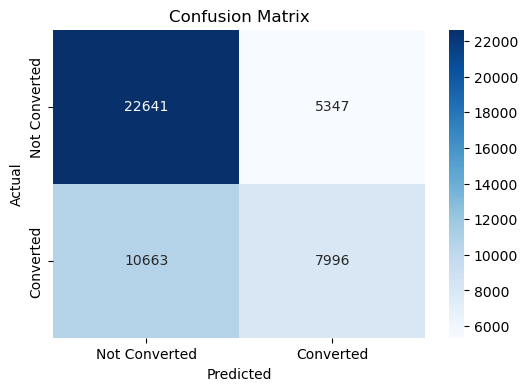

In [191]:
import seaborn as sns
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)

# Plot as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [192]:
# Print the classification report
print('Train\n\n',classification_report(y_train, y_pred_train_bin))#, output_dict=True)
print('Test\n\n',classification_report(y_test, y_pred_bin))#, output_dict=True)

Train

               precision    recall  f1-score   support

         0.0       0.71      0.85      0.77    111952
         1.0       0.68      0.49      0.57     74634

    accuracy                           0.70    186586
   macro avg       0.70      0.67      0.67    186586
weighted avg       0.70      0.70      0.69    186586

Test

               precision    recall  f1-score   support

         0.0       0.68      0.81      0.74     27988
         1.0       0.60      0.43      0.50     18659

    accuracy                           0.66     46647
   macro avg       0.64      0.62      0.62     46647
weighted avg       0.65      0.66      0.64     46647



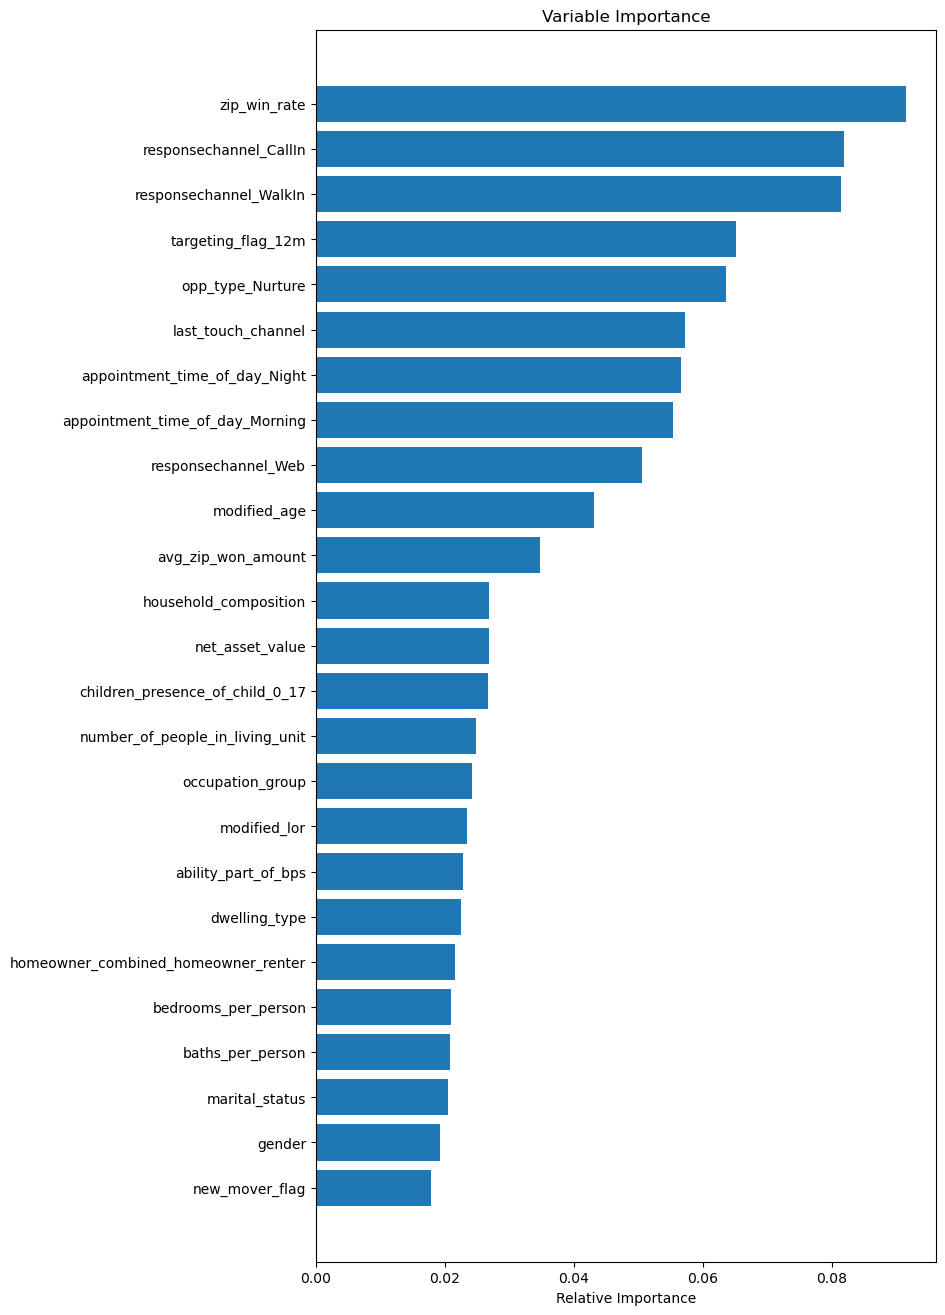

In [193]:
import matplotlib.pyplot as plt
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 16))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
# plt.savefig('SCM_new_v1_Outputs_20250326/Model_Variable_Imp_Graph.png')
plt.show()

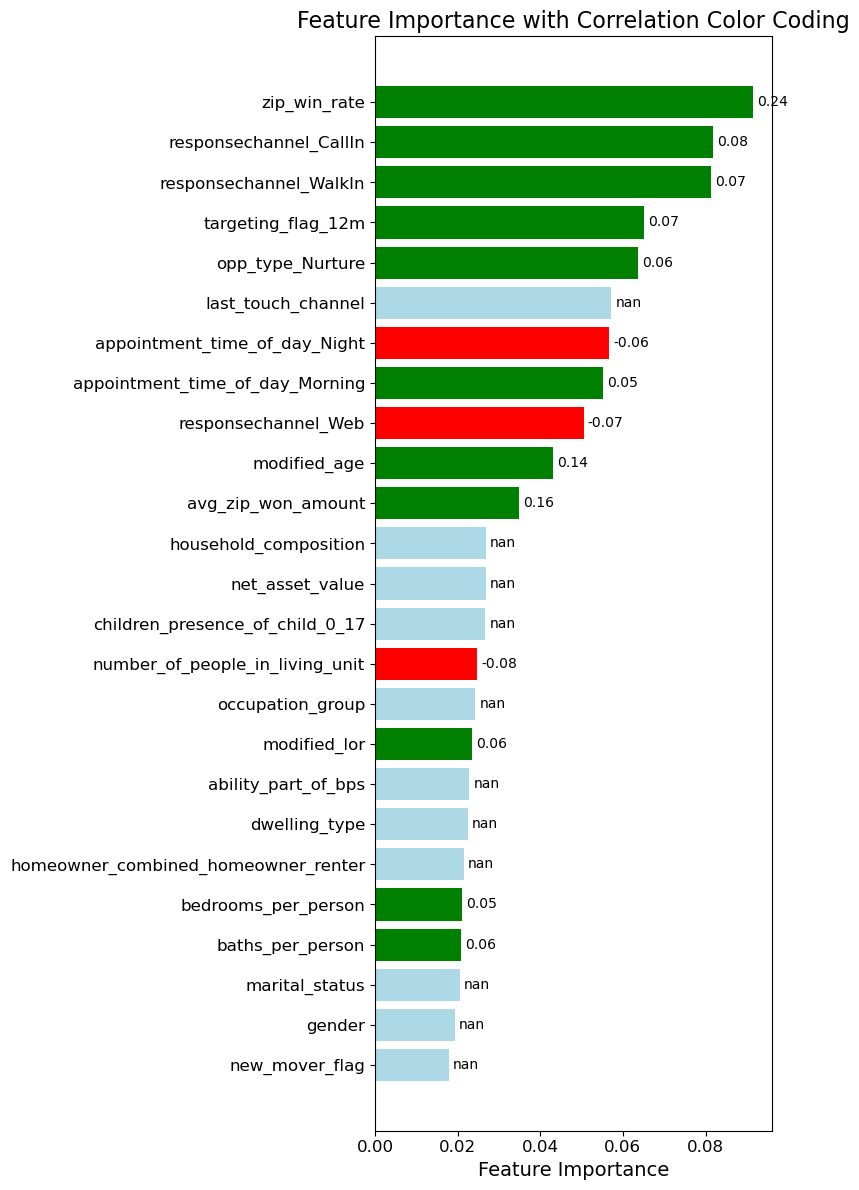

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

importance = xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,  # Use the columns from X_train
    'importance': importance
})

# Step 2: Compute correlation with target
# Ensure only numeric columns are used for correlation computation
numeric_X = X.select_dtypes(include=[np.number])
# Compute correlation between numeric features and the target variable
corrs = pd.concat([pd.DataFrame(y, columns=['final_won_opp']), X[num_cols]], axis=1).corr()['final_won_opp']

# Map the correlation values to the features in the importance DataFrame
importance_df['correlation'] = importance_df['feature'].map(corrs.to_dict())
 
# Step 3: Assign color based on sign of correlation
importance_df['color'] = np.where(importance_df['correlation'].isna(),'lightblue',np.where(importance_df['correlation'] >= 0, 'green', 'red'))
 
# Step 4: Sort and plot
importance_df = importance_df.sort_values('importance', ascending=True)
 
plt.figure(figsize=(8, 12))  # Decrease the box size by reducing figure height
bars = plt.barh(importance_df['feature'], importance_df['importance'], color=importance_df['color'])
plt.xlabel('Feature Importance', fontsize=14)  # Increase font size for labels
plt.title('Feature Importance with Correlation Color Coding', fontsize=16)  # Increase font size for title
plt.xticks(fontsize=12)  # Increase font size for x-axis ticks
plt.yticks(fontsize=12)  # Increase font size for y-axis ticks
 
# Add correlation values as labels
for bar, corr in zip(bars, importance_df['correlation']):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{corr:.2f}', va='center', fontsize=10)  # Adjust font size for correlation labels
 
plt.tight_layout()
plt.show()

In [197]:
out_df=pd.DataFrame()
out_df['features']=X_train.columns[sorted_idx]
out_df['feature_importance']=feature_importance[sorted_idx]
out_df.sort_values(by='feature_importance',ascending=False)

,features,feature_importance
24,zip_win_rate,0.091532
23,responsechannel_CallIn,0.081884
22,responsechannel_WalkIn,0.081381
21,targeting_flag_12m,0.065058
20,opp_type_Nurture,0.063615
19,last_touch_channel,0.057196
18,appointment_time_of_day_Night,0.056630
17,appointment_time_of_day_Morning,0.055296
16,responsechannel_Web,0.050497
15,modified_age,0.043100


In [198]:
out_df.to_clipboard()

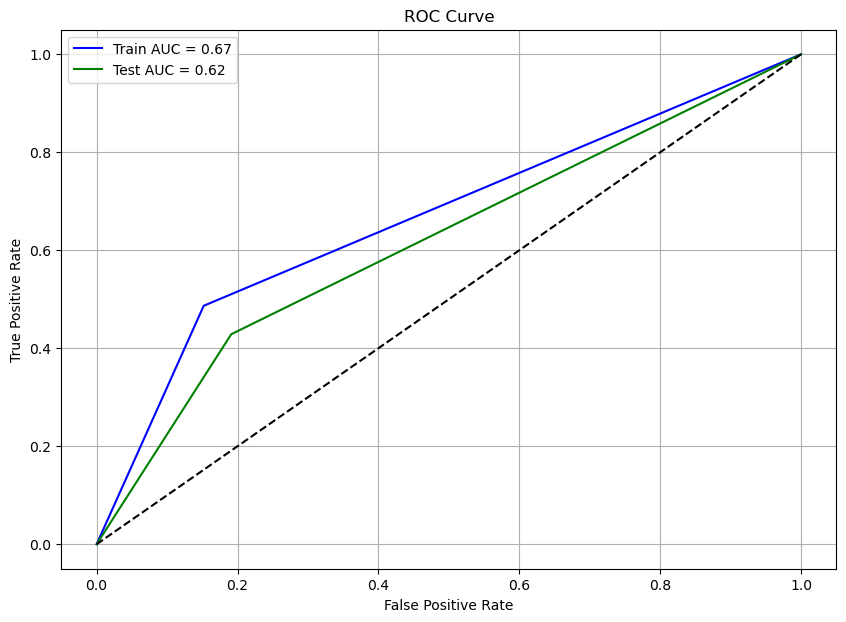

In [199]:
#AuC Plot
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Calculate ROC curve and AUC for train data
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_bin)
auc_train = roc_auc_score(y_train, y_pred_train_bin)

# Calculate ROC curve and AUC for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_bin)
auc_test = roc_auc_score(y_test, y_pred_bin)

# Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}', color='green')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

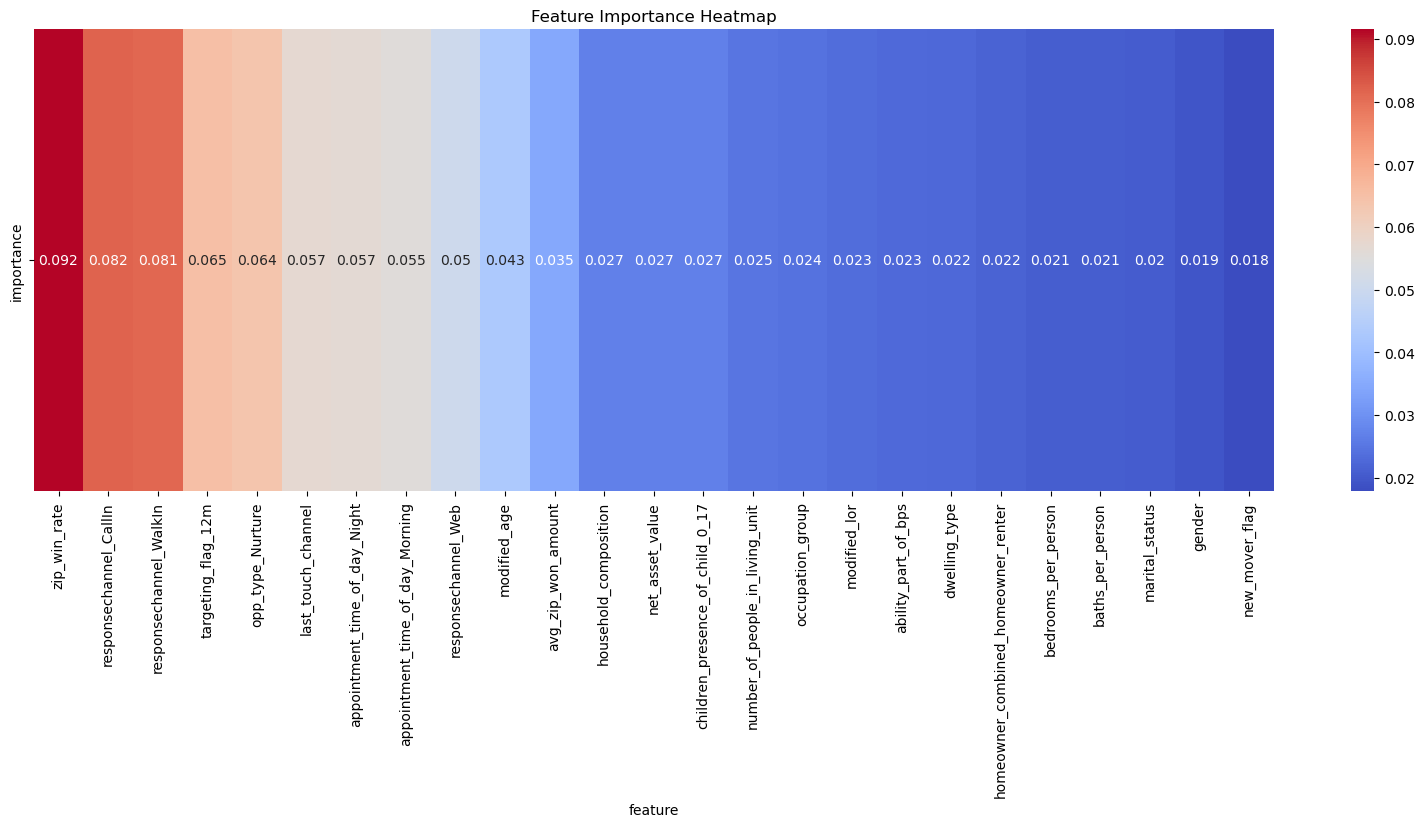

In [200]:
import seaborn as sns
# Create a DataFrame for plotting
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Create a heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(importance_df.set_index('feature').T, annot=True, cmap='coolwarm') # Use 'coolwarm' or other colormap

plt.title('Feature Importance Heatmap')
plt.show()

In [201]:
len(inpt_cols)

25

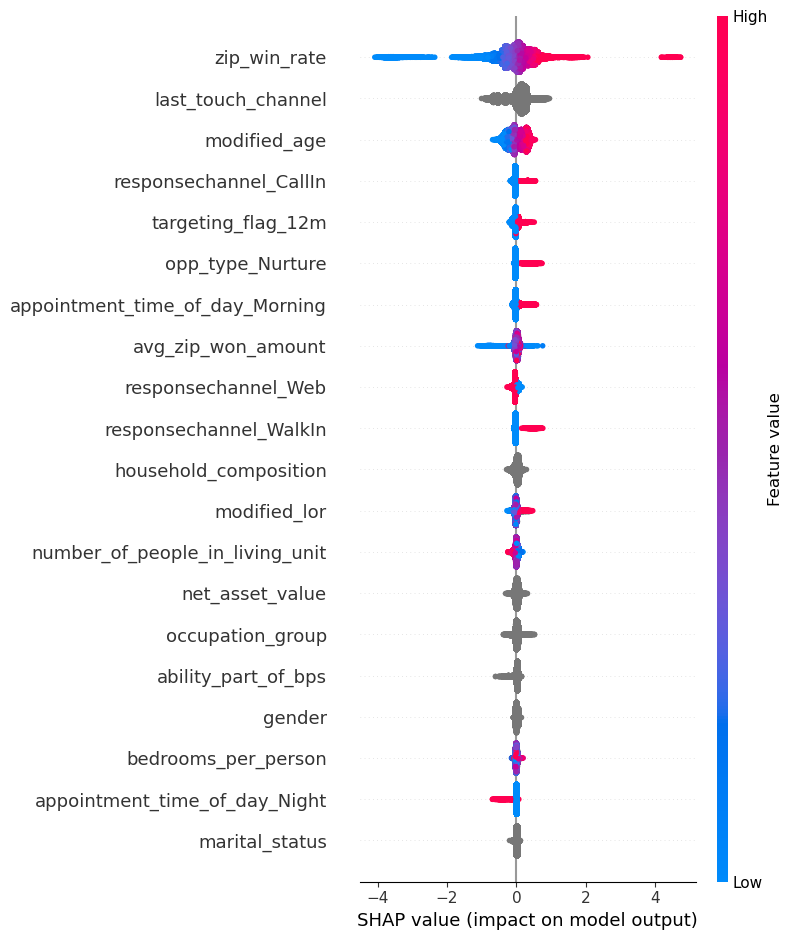

In [202]:
import shap
 
explainer = shap.TreeExplainer(xgb, approximate = True)
shap_values = explainer.shap_values(X_test[inpt_cols])
shap_values.shape
shap.summary_plot(shap_values, X_test[inpt_cols])

### model ends

# Conversion Model Prodiction V2 only for Feb & half Mar

In [203]:
read_file = pd.read_csv('/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_v2_20250522/V2_20250525/DF_Processed.csv',sep='|')
read_file =  read_file[(read_file['creationdate'] >= '2025-02-01') & (read_file['creationdate'] <= '2025-03-31')].copy()
read_file['creationdate'].max()

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_30965/1749520976.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  read_file = pd.read_csv('/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_v2_20250522/V2_20250525/DF_Processed.csv',sep='|')


'2025-03-31'

In [205]:
read_file['creationdate'].min()

'2025-02-01'

In [206]:
model_pickle_mts='/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_v2_20250522/V2_20250525/RFE_file.pkl'
xgb=pickle.load(open(model_pickle_mts, "rb"))

In [207]:
read_file

,addy_zip,zip,city,state,market_gale,est_household_income,children_presence_of_child_0_17,dwelling_type,homeowner_combined_homeowner_renter,household_composition,net_asset_value,number_of_people_in_living_unit,gender,marital_status,occupation_group,new_mover_flag,estimated_current_home_value,property_realty_property_indicator,opportunityid,creationdate,last_touch_channel,is_control,days_bw_creat_to_appt,modified_age,email_12m,email_6m,email_3m,modified_lor,modified_structure_age,modified_years_since_purchase,zip_win_rate,dm_12m,dm_6m,dm_3m,targeting_flag_12m,ttl_targeted_3m,ttl_targeted_6m,ttl_targeted_12m,baths_per_person,bedrooms_per_person,building_square_footage_per_floor,building_to_land_ratio,depth_to_land_ratio,distance_to_showroom_fy25,exterior_wall_type,floor_cover_indicator,front_space_to_land_ratio,gender_coeff,golfcourse_home_200ft,golfcourse_home_200mts,heat_indicator,home_improvement_flag,home_stories,households_median_income,interest_in_home_decor,land_area_perc,land_value_per_sqft,lifestyle_e1,luxury_shopping_e1,waterfront_home,rooms_per_person,total_housing_units,creationdt_is_holiday,vacancy_indicator,dwelling_unit_size,disposable_part_of_bps,ability_part_of_bps,avg_zip_won_amount,zip_median_households_median_income,zip_median_estimated_current_home_value,zip_median_property_realty_home_improvement_value,zip_median_disposable_part_of_bps,zip_median_est_household_income,opp_type_Nurture,responsechannel_CallCenter,responsechannel_CallIn,responsechannel_WalkIn,responsechannel_Web,showroom_type_SelectionCenter,showroom_type_ServiceOnly,showroom_type_Shared(RetailandTrade),creation_month_august,creation_month_december,creation_month_february,creation_month_january,creation_month_july,creation_month_june,creation_month_march,creation_month_may,creation_month_november,creation_month_october,creation_month_september,zip_status_RTZone,appointment_time_of_day_Evening,appointment_time_of_day_Morning,appointment_time_of_day_Night
122438,6926 SUNNYSIDE ST58047,58047.0,HORACE,ND,789 - Minneapolis (Fargo),250.0,1Y,S,H,J,I,6.0,F,1M,K1,N,630200.0,1.0,176ae7,2025-03-17,Other,0.0,15.0,53.0,0.0,0.0,0.0,19.0,26.0,8.5,0.212121,4.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0,0.571429,2500.0,0.172222,0.000000,10.134,5.0,9.0,0.000000,1.039671,0.0,0.0,1.0,1.0,2.0,129722.0,1.0,99.904870,3.600000,0.2633,0.0774,0.0,1.428572,1519.0,0,0.0,1.0,1.0,B,2554.7166,129722.0,574300.0,176.0,1.0,225.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
125059,1437 CATALINA92651,92651.0,LAGUNA BEACH,CA,711 - Los Angeles,225.0,5N,S,H,C,J,2.0,M,1M,K3,N,2648000.0,1.0,19565025,2025-02-03,SEM,0.0,2.0,82.0,0.0,0.0,0.0,24.0,47.0,25.0,0.141176,17.0,9.0,3.0,1.0,3.0,9.0,17.0,1.0,1.000000,2100.0,0.700000,0.000000,70.385,7.0,0.0,0.000000,0.987135,0.0,0.0,0.0,1.0,1.0,138734.0,1.0,87.493546,269.000000,0.2716,0.0659,0.0,3.000000,13493.0,0,0.0,1.0,2.0,B,3606.8850,138734.0,3036400.0,213.0,1.0,250.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
125060,2755 BRIARFIELD WAY30043,30043.0,LAWRENCEVILLE,GA,720 - Atlanta,65.0,1Y,S,H,J,B,6.0,F,5S,K1,N,408100.0,1.0,19565732,2025-02-03,PellaBranch.com,0.0,8.0,38.0,0.0,0.0,0.0,12.0,37.0,13.0,0.115942,2.0,2.0,1.0,1.0,1.0,2.0,2.0,0.0,0.500000,4600.0,0.200000,0.000000,14.466,6.0,0.0,0.000000,0.942357,0.0,0.0,1.0,1.0,1.0,81640.0,1.0,98.820015,1.434783,0.0502,0.0264,0.0,1.000000,30184.0,0,0.0,1.0,4.0,A,2100.5073,81640.0,483700.0,138.0,4.0,105.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
125061,24043 LATHRUP BLVD48075,48075.0,SOUTHFIELD,MI,742 - Detroit,65.0,1Y,A,H,G,A,4.0,M,5S,K1,N,204800.0,2.0,19583915,2025-02-04,Pella.com,0.0,1.0,36.0,0.0,0.0,0.0,0.0,26.0,1.0,0.148649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,1750.0,0.262879,0.013500,22.181,4.0,0.0,0.007236,0.809850,0.0,0.0,1.0,0.0,1.0,61716.0,0.0,100.000000,1.722222,0.0785,0.0349,0.0,0.000000,10353.0,0,0.0,5.0,5.0,C,1504.1375,61716.0,279350.0,87.0,4.0,95.0,0.0,1.0,

In [208]:
read_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9895 entries, 122438 to 220236
Data columns (total 96 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   addy_zip                                           9895 non-null   object 
 1   zip                                                9895 non-null   float64
 2   city                                               9895 non-null   object 
 3   state                                              9895 non-null   object 
 4   market_gale                                        9895 non-null   object 
 5   est_household_income                               9895 non-null   float64
 6   children_presence_of_child_0_17                    9895 non-null   object 
 7   dwelling_type                                      9895 non-null   object 
 8   homeowner_combined_homeowner_renter                9895 non-null   object 
 9   househ

In [209]:
read_file = read_file.astype({col: 'float32' for col in read_file.select_dtypes(include='float64').columns})
read_file = read_file.astype({col: 'float32' for col in read_file.select_dtypes(include='int64').columns})
read_file = read_file.astype({col: 'str' for col in read_file.select_dtypes(include='object').columns})

In [210]:
read_file1 = read_file.copy()

In [211]:
obj_final=read_file.select_dtypes('object').columns
read_file[obj_final]=read_file[obj_final].apply(lambda x: x.astype('category'))

In [212]:
read_file=read_file[inpt_cols]

In [213]:
read_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9895 entries, 122438 to 220236
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   zip_win_rate                         9895 non-null   float32 
 1   avg_zip_won_amount                   9895 non-null   float32 
 2   modified_age                         9895 non-null   float32 
 3   responsechannel_CallIn               9895 non-null   float32 
 4   number_of_people_in_living_unit      9872 non-null   float32 
 5   responsechannel_Web                  9895 non-null   float32 
 6   targeting_flag_12m                   9895 non-null   float32 
 7   responsechannel_WalkIn               9895 non-null   float32 
 8   modified_lor                         9885 non-null   float32 
 9   opp_type_Nurture                     9895 non-null   float32 
 10  appointment_time_of_day_Night        9895 non-null   float32 
 11  baths_per_perso

In [214]:
inpt_cols

['zip_win_rate',
 'avg_zip_won_amount',
 'modified_age',
 'responsechannel_CallIn',
 'number_of_people_in_living_unit',
 'responsechannel_Web',
 'targeting_flag_12m',
 'responsechannel_WalkIn',
 'modified_lor',
 'opp_type_Nurture',
 'appointment_time_of_day_Night',
 'baths_per_person',
 'appointment_time_of_day_Morning',
 'bedrooms_per_person',
 'children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'new_mover_flag',
 'last_touch_channel',
 'ability_part_of_bps']

In [215]:
y_pred_full_data = xgb.predict_proba(read_file)[:,1]

In [216]:
y_pred_full_data

array([0.470608  , 0.478356  , 0.19744839, ..., 0.57568425, 0.22368567,
       0.27008334], dtype=float32)

In [217]:
read_file['pred_prob']=y_pred_full_data

In [218]:
y_pred_full_data

array([0.470608  , 0.478356  , 0.19744839, ..., 0.57568425, 0.22368567,
       0.27008334], dtype=float32)

In [219]:
%%time
pred_out='/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_v2_20250522/V2_20250525/Prediction_Output_for_202502_202503.csv'
read_file1['pred_prob']=y_pred_full_data
read_file1[['opportunityid','addy_zip','zip','pred_prob']].to_csv(pred_out,sep='|',index=False)

CPU times: user 15.3 ms, sys: 2.81 ms, total: 18.1 ms
Wall time: 19.1 ms


# DONE PREDICTING

In [207]:
read_file1['opportunityid'].nunique()

9895

# RFE

In [491]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix, f1_score, classification_report

X_train_rfe = df3.copy()
y_train_rfe = y.copy()

X_test_rfe = x_test[inpt_cols]
y_test_rfe = test_df.final_won_opp
print(X_train_rfe.dtypes)

cols_obj  = X_test_rfe.select_dtypes('category').columns.to_list()
#print(cols_obj)   ['dwelling_type', 'homeowner_combined_homeowner_renter', 'household_composition', 'buying_power_score']
# del cols
cols  = X_test_rfe.select_dtypes(exclude = ['category']).columns.to_list()
cols.extend(['dt', 'hr', 'hc'])

zip_win_rate                            float32
avg_zip_won_amount                      float32
modified_age                            float32
responsechannel_CallIn                  float32
number_of_people_in_living_unit         float32
responsechannel_Web                     float32
targeting_flag_12m                      float32
responsechannel_WalkIn                  float32
modified_lor                            float32
opp_type_Nurture                        float32
appointment_time_of_day_Night           float32
baths_per_person                        float32
appointment_time_of_day_Morning         float32
bedrooms_per_person                     float32
children_presence_of_child_0_17        category
dwelling_type                          category
homeowner_combined_homeowner_renter    category
household_composition                  category
net_asset_value                        category
gender                                 category
marital_status                         c

In [492]:
%%time
le = OrdinalEncoder()
le.fit(X_train[['dwelling_type', 'homeowner_combined_homeowner_renter', 'household_composition']])

X_train_rfe[['dt', 'hr', 'hc']] = le.transform(X_train[['dwelling_type', 'homeowner_combined_homeowner_renter', 'household_composition']])
X_test_rfe[['dt', 'hr', 'hc']] = le.transform(X_test[['dwelling_type', 'homeowner_combined_homeowner_renter', 'household_composition']])

CPU times: user 61.7 ms, sys: 5.94 ms, total: 67.7 ms
Wall time: 68 ms


<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [493]:
X_train_rfe[cols]

,zip_win_rate,avg_zip_won_amount,modified_age,responsechannel_CallIn,number_of_people_in_living_unit,responsechannel_Web,targeting_flag_12m,responsechannel_WalkIn,modified_lor,opp_type_Nurture,appointment_time_of_day_Night,baths_per_person,appointment_time_of_day_Morning,bedrooms_per_person,dt,hr,hc
119316,0.102804,1838.584351,62.0,0.0,5.0,0.0,1.0,0.0,23.0,0.0,0.0,1.0,0.0,0.800000,2.0,0.0,6.0
455532,0.214286,3824.173096,58.0,0.0,4.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.666667,2.0,0.0,3.0
396848,0.421053,5350.251953,77.0,0.0,2.0,1.0,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.000000,2.0,0.0,2.0
333214,0.211765,2941.378418,61.0,0.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,8.0
379650,0.272727,4192.798828,54.0,0.0,6.0,1.0,0.0,0.0,16.0,0.0,0.0,0.0,1.0,0.000000,2.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153968,0.136905,2345.434326,68.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.000000,2.0,0.0,4.0
461021,0.211207,3021.870850,58.0,1.0,5.0,0.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.800000,2.0,0.0,3.0
329902,0.153846,2080.199219,58.0,0.0,4.0,0.0,1.0,0.0,24.0,0.0,0.0,0.0,0.0,0.708333,2.0,1.0,7.0
151853,0.271186,3665.508789,77.0,0.0,1.0,1.0,0.0,0.0,16.0,0.0,0.0,2.0,0.0,2.000000,2.0,0.0,0.0


In [494]:
sf = corr_based_MRMR(corr_matrix(X_train_rfe[cols].join(pd.DataFrame(y_train)),'final_won_opp'), 0.01, 0.8)

Count of selected Features  16


In [495]:
sf

['zip_win_rate',
 'avg_zip_won_amount',
 'modified_age',
 'responsechannel_CallIn',
 'number_of_people_in_living_unit',
 'responsechannel_Web',
 'targeting_flag_12m',
 'responsechannel_WalkIn',
 'opp_type_Nurture',
 'modified_lor',
 'baths_per_person',
 'appointment_time_of_day_Night',
 'appointment_time_of_day_Morning',
 'bedrooms_per_person',
 'hc',
 'dt']

In [500]:
params = {
            'objective':'binary:logistic',
            'max_depth': 10,
            'eval_metric':'auc',
            'alpha': 15,
            'learning_rate': 0.04,
            'n_estimators':200,
            'min_child_weight':10,
            'enable_categorical': True
        }      


rfe = RFE(estimator=XGBClassifier(**params), n_features_to_select=10,step = 2 , verbose=1)
# Fit the RFE object with the XGBoost model and the training data
rfe.fit(X_train_rfe[sf], y_train_rfe)
rfe_data = {}
rfe_data['accuracy_test'] = rfe.score(X_test_rfe[sf], y_test_rfe)
rfe_data['accuracy_train'] = rfe.score(X_train_rfe[sf], y_train_rfe)
rfe_data['f1_score'] = metrics.f1_score(y_test_rfe,rfe.predict(X_test_rfe[sf]),average='weighted')
rfe_data['support'] = rfe.support_
rfe_data['ranking'] = rfe.ranking_
rfe_data

Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.


{'accuracy_test': 0.646215190687504,
 'accuracy_train': 0.6566945001232676,
 'f1_score': 0.6254594752770206,
 'support': array([ True, False,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True, False, False, False]),
 'ranking': array([1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 3, 2, 3])}

In [501]:
r = rfe_data['ranking']

print(r)

[1 4 1 1 2 1 1 1 1 1 4 1 1 3 2 3]


In [502]:
score_data = {}
for i in range (1,max(r)+1,1):
    print(i)
    s = []
    for j in range(len(sf)):
        if i >= r[j]:
            print(sf[j])
            s.append(sf[j])
    print('number of features:', len(s))
    
    model = XGBClassifier(**params)

    model.fit(X_train_rfe[s], y_train_rfe)
    score_data[len(s)] = {}
    score_data[len(s)]['accuracy'] = model.score(X_test_rfe[s], y_test_rfe.ravel())
    score_data[len(s)]['accuracy_train'] = model.score(X_train_rfe[s], y_train_rfe.ravel())
    score_data[len(s)]['f1_score'] = metrics.f1_score(y_test_rfe.ravel(),model.predict(X_test_rfe[s]),average='weighted')
    score_data[len(s)]['f1_score_train'] = metrics.f1_score(y_train_rfe.ravel(),model.predict(X_train_rfe[s]),average='weighted')
    score_data[len(s)]['auc_test'] = metrics.roc_auc_score(y_test_rfe.ravel(),model.predict_proba(X_test_rfe[s])[:,1])
    score_data[len(s)]['auc_train'] = metrics.roc_auc_score(y_train_rfe.ravel(),model.predict_proba(X_train_rfe[s])[:,1])
    score_data[len(s)]['columns'] = s

k = list(score_data.keys())
x = [len(score_data[i]['columns']) for i in k]
y_acc = [score_data[i]['accuracy'] for i in k]
t_acc = [score_data[i]['accuracy_train'] for i in k]
y_auc = [score_data[i]['auc_test'] for i in k]
t_auc = [score_data[i]['auc_train'] for i in k]
y_f1_score = [score_data[i]['f1_score'] for i in k]
t_f1_score = [score_data[i]['f1_score_train'] for i in k]

1
zip_win_rate
modified_age
responsechannel_CallIn
responsechannel_Web
targeting_flag_12m
responsechannel_WalkIn
opp_type_Nurture
modified_lor
appointment_time_of_day_Night
appointment_time_of_day_Morning
number of features: 10


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['accuracy'] = model.score(X_test_rfe[s], y_test_rfe.ravel())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['accuracy_train'] = model.score(X_train_rfe[s], y_train_rfe.ravel())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['f1_score'] = metrics.f1_score(y_test_rfe.ravel(),model.predict

2
zip_win_rate
modified_age
responsechannel_CallIn
number_of_people_in_living_unit
responsechannel_Web
targeting_flag_12m
responsechannel_WalkIn
opp_type_Nurture
modified_lor
appointment_time_of_day_Night
appointment_time_of_day_Morning
hc
number of features: 12


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['accuracy'] = model.score(X_test_rfe[s], y_test_rfe.ravel())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['accuracy_train'] = model.score(X_train_rfe[s], y_train_rfe.ravel())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['f1_score'] = metrics.f1_score(y_test_rfe.ravel(),model.predict

3
zip_win_rate
modified_age
responsechannel_CallIn
number_of_people_in_living_unit
responsechannel_Web
targeting_flag_12m
responsechannel_WalkIn
opp_type_Nurture
modified_lor
appointment_time_of_day_Night
appointment_time_of_day_Morning
bedrooms_per_person
hc
dt
number of features: 14


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['accuracy'] = model.score(X_test_rfe[s], y_test_rfe.ravel())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['accuracy_train'] = model.score(X_train_rfe[s], y_train_rfe.ravel())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['f1_score'] = metrics.f1_score(y_test_rfe.ravel(),model.predict

4
zip_win_rate
avg_zip_won_amount
modified_age
responsechannel_CallIn
number_of_people_in_living_unit
responsechannel_Web
targeting_flag_12m
responsechannel_WalkIn
opp_type_Nurture
modified_lor
baths_per_person
appointment_time_of_day_Night
appointment_time_of_day_Morning
bedrooms_per_person
hc
dt
number of features: 16


/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['accuracy'] = model.score(X_test_rfe[s], y_test_rfe.ravel())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['accuracy_train'] = model.score(X_train_rfe[s], y_train_rfe.ravel())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_52478/4096479806.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score_data[len(s)]['f1_score'] = metrics.f1_score(y_test_rfe.ravel(),model.predict

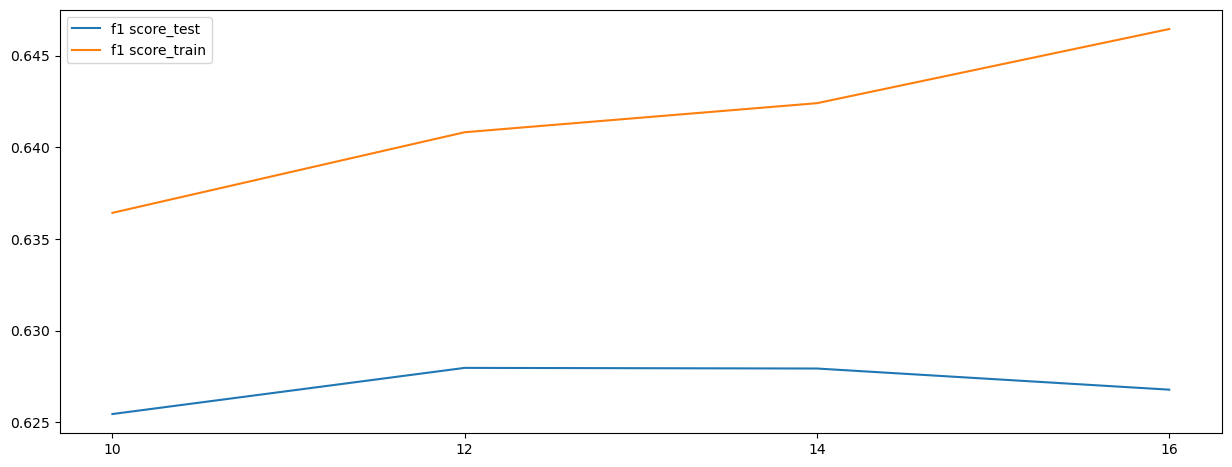

In [503]:
plt.plot(x,y_f1_score, label = "f1 score_test")
plt.plot(x,t_f1_score, label = "f1 score_train")
plt.legend()
plt.xticks(x)
plt.rcParams["figure.figsize"] = (15,5.5)
plt.show()

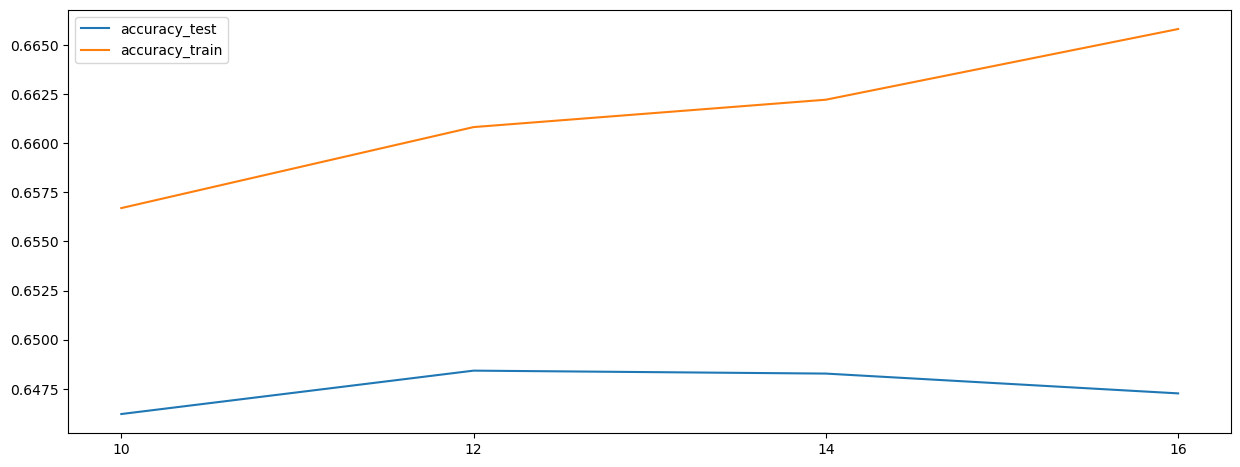

In [504]:
plt.plot(x,y_acc, label = "accuracy_test")
plt.plot(x, t_acc, label = "accuracy_train")
plt.legend()
plt.xticks(x)
plt.rcParams["figure.figsize"] = (15,5.5)
plt.show()

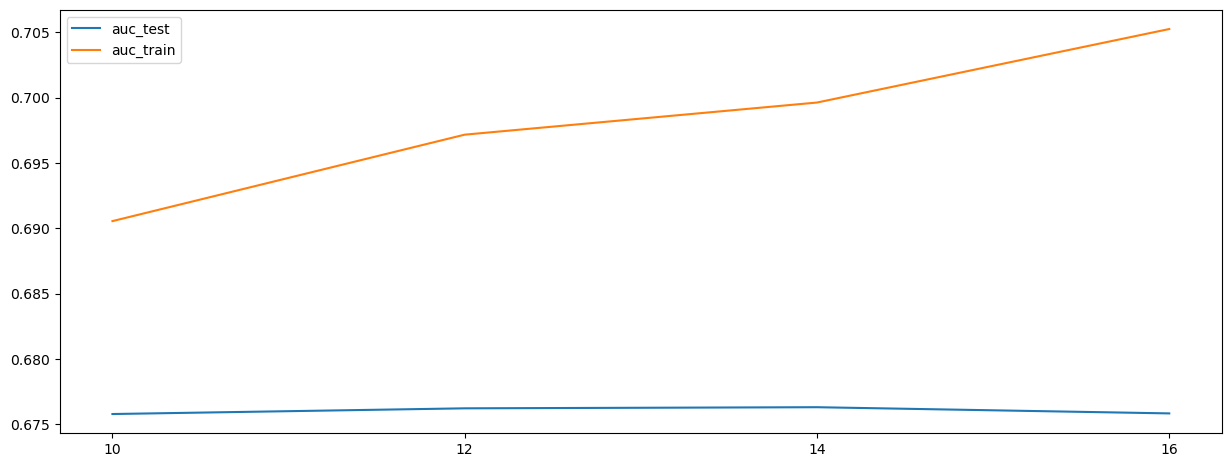

In [505]:
plt.plot(x,y_auc, label = "auc_test")
plt.plot(x,t_auc, label = "auc_train")
plt.legend()
plt.xticks(x)
plt.rcParams["figure.figsize"] = (15,5.5)
plt.show()

In [506]:
feat_df = pd.DataFrame()
feat_df['col'] = sf
feat_df['value'] = rfe_data['ranking']

In [508]:
feat_df[feat_df['value']<14].col.values

array(['zip_win_rate', 'avg_zip_won_amount', 'modified_age',
       'responsechannel_CallIn', 'number_of_people_in_living_unit',
       'responsechannel_Web', 'targeting_flag_12m',
       'responsechannel_WalkIn', 'opp_type_Nurture', 'modified_lor',
       'baths_per_person', 'appointment_time_of_day_Night',
       'appointment_time_of_day_Morning', 'bedrooms_per_person', 'hc',
       'dt'], dtype=object)

In [509]:
len(feat_df[feat_df['value']<14].col.values)

16

<!-- 'buying_power_score', 'opp_rate', 'homeowner_combined_homeowner_renter', 'dwelling_type','number_of_fireplaces',
       'building_square_footage_per_floor',
       'phone_1_lifetime_value_score', 'interest_in_luxury_life',
       'dwelling_unit_size', 'marital_status', 'interest_in_home_decor',
       'home_improvement_flag', 'estimated_current_home_value',
       'education_model_binary', 'property_realty_property_indicator',
       'owns_a_landline', 'structure_age', 'swimming_pool_flag',
       'air_conditioning', 'home_appreciation', 'exact_age',
       'number_of_people_in_living_unit', 'gender', 'snow_days_to_avg',
       'vacancy_indicator', 'county_total_area' -->ture_flag'

In [510]:
df3.columns

Index(['zip_win_rate', 'avg_zip_won_amount', 'modified_age',
       'responsechannel_CallIn', 'number_of_people_in_living_unit',
       'responsechannel_Web', 'targeting_flag_12m', 'responsechannel_WalkIn',
       'modified_lor', 'opp_type_Nurture', 'appointment_time_of_day_Night',
       'baths_per_person', 'appointment_time_of_day_Morning',
       'bedrooms_per_person', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'last_touch_channel',
       'ability_part_of_bps'],
      dtype='object')

In [511]:
X_train = df3.copy()[['modified_age', 'number_of_people_in_living_unit', 'targeting_flag',
       'responsechannel_Call In', 'responsechannel_Walk In',
       'responsechannel_Web', 'modified_lor', 'opp_type_Nurture',
       'baths_per_person', 'bedrooms_per_person', 'market_gale',
       'children_presence_of_child_0_17', 'dwelling_type',
       'homeowner_combined_homeowner_renter', 'household_composition',
       'buying_power_score', 'net_asset_value', 'gender', 'marital_status',
       'occupation_group', 'ethnic_group', 'religion', 'creation_day_of_week',
       'creation_month', 'creation_time_of_day', 'appointment_day_of_week',
       'appointment_month', 'appointment_time_of_day', 'zip_status'
                     ]]
y_train = y.copy()

X_test = x_test[['modified_age', 'number_of_people_in_living_unit', 'targeting_flag',
       'responsechannel_Call In', 'responsechannel_Walk In',
       'responsechannel_Web', 'modified_lor', 'opp_type_Nurture',
       'baths_per_person', 'bedrooms_per_person', 'market_gale',
       'children_presence_of_child_0_17', 'dwelling_type',
       'homeowner_combined_homeowner_renter', 'household_composition',
       'buying_power_score', 'net_asset_value', 'gender', 'marital_status',
       'occupation_group', 'ethnic_group', 'religion', 'creation_day_of_week',
       'creation_month', 'creation_time_of_day', 'appointment_day_of_week',
       'appointment_month', 'appointment_time_of_day', 'zip_status']]
y_test = test_df.final_won_opp

params = {
            'objective':'binary:logistic',
            'max_depth': 10,
            'eval_metric':'auc',
            'alpha': 15,
            'learning_rate': 0.04,
            'n_estimators':200,
            'min_child_weight':10,
            'enable_categorical': True
        }      

xgb = XGBClassifier(**params)

xgb.fit(X_train, y_train)

pickle.dump(xgb, open(model_pickle_mts, "wb")) ## Need to change

y_pred = xgb.predict_proba(X_test)[:,1]
y_pred_train=xgb.predict_proba(X_train)[:,1]


print('Train AUC = ' + str(roc_auc_score(y_train,y_pred_train).round(4)))
print('Test AUC = ' + str(roc_auc_score(y_test,y_pred).round(4)))

y_pred_bin = xgb.predict(X_test)
y_pred_train_bin=xgb.predict(X_train)
#confusion_matrix(y_test, y_pred_bin)


KeyError: "['targeting_flag', 'responsechannel_Call In', 'responsechannel_Walk In', 'market_gale', 'buying_power_score', 'ethnic_group', 'religion', 'creation_day_of_week', 'creation_month', 'creation_time_of_day', 'appointment_day_of_week', 'appointment_month', 'appointment_time_of_day', 'zip_status'] not in index"

In [ ]:
X_train.columns.to_list()

['modified_age',
 'number_of_people_in_living_unit',
 'targeting_flag',
 'responsechannel_Call In',
 'responsechannel_Walk In',
 'responsechannel_Web',
 'modified_lor',
 'opp_type_Nurture',
 'baths_per_person',
 'bedrooms_per_person',
 'market_gale',
 'children_presence_of_child_0_17',
 'dwelling_type',
 'homeowner_combined_homeowner_renter',
 'household_composition',
 'buying_power_score',
 'net_asset_value',
 'gender',
 'marital_status',
 'occupation_group',
 'ethnic_group',
 'religion',
 'creation_day_of_week',
 'creation_month',
 'creation_time_of_day',
 'appointment_day_of_week',
 'appointment_month',
 'appointment_time_of_day',
 'zip_status']

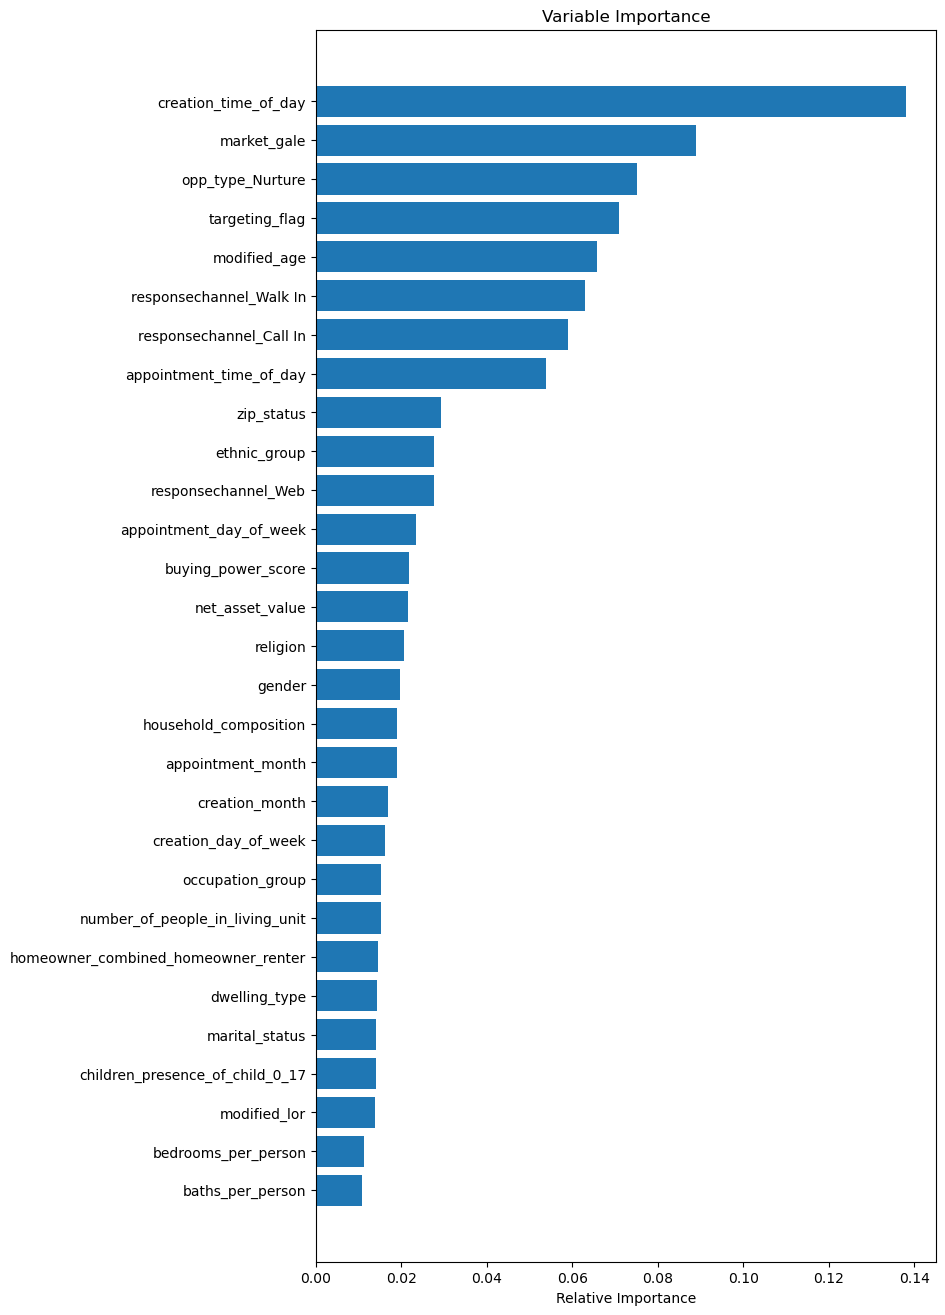

In [ ]:
import matplotlib.pyplot as plt
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 16))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('RFE_feature_Importance.png')
plt.show()

In [ ]:
print('TRAIN',end = '\n\n')
print(classification_report(y_train, y_pred_train_bin))#, output_dict=True)
print('TEST',end = '\n\n')
print(classification_report(y_test, y_pred_bin))#, output_dict=True)

TRAIN

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81     82905
         1.0       0.69      0.24      0.35     41453

    accuracy                           0.71    124358
   macro avg       0.70      0.59      0.58    124358
weighted avg       0.71      0.71      0.66    124358

TEST

              precision    recall  f1-score   support

         0.0       0.69      0.94      0.80     20727
         1.0       0.58      0.17      0.27     10363

    accuracy                           0.68     31090
   macro avg       0.64      0.56      0.53     31090
weighted avg       0.66      0.68      0.62     31090



# For Prediction 

In [216]:
df1=df.copy()
df1 = df1[(df1['creationdate'] >= '2025-02-01') & (df1['creationdate'] <= '2025-03-31')].copy()
df1.columns

KeyError: 'creationdate'

In [174]:
%%time
import numpy as np
import pandas as pd
import pickle
import sys

from functools import reduce
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor

CPU times: user 34 μs, sys: 237 μs, total: 271 μs
Wall time: 666 μs


In [ ]:
%%time
chunksize = 10**6  # Adjust the chunk size to fit your memory capacity
chunk_list = []  # To hold chunks

for chunk in pd.read_csv('/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_new_v2_20250416/V2_20250416/Validation_input_file.csv', sep='|', chunksize=chunksize):
    # Process each chunk here if needed
    chunk_list.append(chunk)

df_1 = pd.concat(chunk_list) 

<timed exec>:4: DtypeWarning: Columns (159,227) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 6.94 s, sys: 2.09 s, total: 9.02 s
Wall time: 10.1 s


In [212]:
df_1.shape

(452294, 295)

In [213]:
df_1['dwelling_unit_size'].unique()

array(['A', 'B', 'E', nan, 'C', 'D', 'G', 'I', 'F', 'H'], dtype=object)

In [214]:
df_1['dwelling_unit_size'].isna().sum()

2531

In [ ]:
df_1 = df_1[(df_1['creationdate'] >= '2025-02-01') & (df['creationdate'] <= '2025-03-31')].copy()

In [215]:
df['vacancy_indicator_1']=df['vacancy_indicator'].map({'Y':1,'N':0}).astype('float32') 

df['dwelling_unit_size_1']=df['dwelling_unit_size'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':10,'G':20,'H':50,'I':101}).astype('float32')
 
df.drop(['vacancy_indicator','dwelling_unit_size'],axis=1,inplace=True)
df.rename(columns={
                   'vacancy_indicator_1':'vacancy_indicator' , 'dwelling_unit_size_1':'dwelling_unit_size'
                   },inplace=True)

In [182]:
df.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'last_touch_channel',
       'is_control', 'final_won_opp', 'days_bw_creat_to_appt', 'modified_age',
       'email_12m', 'email_6m', 'email_3m', 'modified_lor',
       'modified_structure_age', 'modified_years_since_purchase',
       'zip_win_rate', 'dm_12m', 'dm_6m', 'dm_3m', 'targeting_flag_12m',
       'ttl_targeted_3m', 'ttl_targeted_6m', 'ttl_targeted_12m',
       'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'exterior_wall_type

In [183]:
df_1.columns

Index(['addy_zip', 'zip', 'city', 'state', 'market_gale',
       'est_household_income', 'children_presence_of_child_0_17',
       'dwelling_type', 'homeowner_combined_homeowner_renter',
       'household_composition', 'net_asset_value',
       'number_of_people_in_living_unit', 'gender', 'marital_status',
       'occupation_group', 'new_mover_flag', 'estimated_current_home_value',
       'property_realty_property_indicator', 'last_touch_channel',
       'is_control', 'final_won_opp', 'days_bw_creat_to_appt', 'modified_age',
       'email_12m', 'email_6m', 'email_3m', 'modified_lor',
       'modified_structure_age', 'modified_years_since_purchase',
       'zip_win_rate', 'dm_12m', 'dm_6m', 'dm_3m', 'targeting_flag_12m',
       'ttl_targeted_3m', 'ttl_targeted_6m', 'ttl_targeted_12m',
       'baths_per_person', 'bedrooms_per_person',
       'building_square_footage_per_floor', 'building_to_land_ratio',
       'depth_to_land_ratio', 'distance_to_showroom_fy25',
       'exterior_wall_type

In [184]:
nv_df=pd.read_csv('/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_new_v2_20250416/V2_20250416/NV_DF.csv',sep='|')
outlier_bounds=pd.read_csv('/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_new_v2_20250416/V2_20250416/Outlier.csv',sep='|')

In [185]:
#outlier_bounds.drop(['Unnamed: 0'],axis=1,inplace=True)
outlier_bounds=outlier_bounds.to_dict()

In [186]:
median_cols=[#'bath_to_room_ratio',
            'baths_per_person',
            'bedrooms_per_person',
            # 'building_area_per_room',
            'building_square_footage_per_floor',
            'building_to_land_ratio',
            # 'county_area_perc',
            'county_total_area',
            'depth_to_land_ratio',
            'est_household_income',
            'estimated_current_home_value',
            'front_space_to_land_ratio',
            'gender_coeff',
            'households_median_income',
            'home_appreciation',
            'home_decor_e1',
            'home_land_square_footage',
            'home_purchase_price',
            'home_stories',
            'home_value_per_sqft',
            'land_area_perc',
            'land_value_per_sqft',
            'lifestyle_e1',
            'luxury_shopping_e1',
            'modified_age',
             'modified_lor',
             'modified_structure_age',
             'modified_years_since_purchase',
            'number_of_adults_in_living_unit',
            'number_of_people_in_living_unit',
            'number_of_vehicles',
            'percentage_adults_in_living_unit',
            'rain_days_to_avg',
            'rooms_per_person',
            # 'snow_days_to_avg',
            #'structure_age',
            'total_housing_units',
            'total_population',
             'water_area_perc',
            # 'zip_total_area',
            'distance_to_showroom_fy25'
            ,'zip_avg_job_size'
        #     'avg_zip_won_amount',
            ,'zip_median_households_median_income',
            'zip_median_estimated_current_home_value',
            'zip_median_property_realty_home_improvement_value',
            'zip_median_disposable_part_of_bps',
            'zip_median_est_household_income'
            ]
mode_cols=['air_conditioning',
        # 'building_construction_indicator',
        'buying_power_score',
        'children_presence_of_child_0_17',
        # 'country_of_origin',
        'dwelling_type',
        'dwelling_unit_size',
        # 'ethnic_group',
        'exterior_wall_type',
        'floor_cover_indicator',
        'gender',
        'golfcourse_home_200ft',
        'golfcourse_home_200mts',
        'heat_indicator',
        'home_decor_e1',
        'home_improvement_flag',
        'homeowner_combined_homeowner_renter',
        'household_composition',
        # 'interest_in_arts_and_crafts',
        'interest_in_home_decor',
        'lifestyle_e1', 
        'luxury_shopping_e1',
        'marital_status',
        'marketing_tactic',
        'marketing_type',
        'net_asset_value',
        'occupation_code',
        'occupation_group',
        'property_realty_property_indicator',
        # 'religion',
        'vacancy_indicator',
        'waterfront_home'
        ,'appointment_day_of_week'
        ,'appointment_month'
        ,'appointment_time_of_day'
        ,'appointment_time_of_month'
        ,'appointment_dt_seasons' 
        ,'disposable_part_of_bps'
        ,'ability_part_of_bps'
        ,'days_bw_creat_to_appt'
]

In [187]:
# Imputing non-binary numerical columns with median at zip, county, state level

def clean_data_median1(df, i):
    try:
        df.loc[:, i] = df[i].fillna(df.groupby('zip')[i].transform('median'))
    except:
        print(i, "ERROR")
        pass

def clean_data_median2(df, i):
    try:
        df.loc[:, i] = df[i].fillna(df.groupby('county')[i].transform('median'))
    except:
        print(i, "ERROR")
        pass

def clean_data_median3(df, i):
    try:
        df.loc[:, i] = df[i].fillna(df.groupby('state')[i].transform('median'))
    except:
        print(i, "ERROR")
        pass

def clean_data_median4(df, i):
    try:
        df.loc[:, i] = df[i].fillna(df.groupby('market_gale')[i].transform('median'))
    except:
        print(i, "ERROR")
        pass

# Imputing categorical columns with mode at zip, county, state level

def clean_data_mode1(df, col):
    try:
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
        df.loc[:, col] = df.groupby('zip')[col].transform(lambda x: x.fillna(mode_func(x)))
    except:
        print(col, "ERROR")
        pass

def clean_data_mode2(df, col):
    try:
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
        df.loc[:, col] = df.groupby('county')[col].transform(lambda x: x.fillna(mode_func(x)))
    except:
        print(col, "ERROR")
        pass

def clean_data_mode3(df, col):
    try:
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
        df.loc[:, col] = df.groupby('state')[col].transform(lambda x: x.fillna(mode_func(x)))
    except:
        print(col, "ERROR")
        pass

def clean_data_mode4(df, col):
    try:
        mode_func = lambda x: x.mode()[0] if not x.mode().empty else x
        df.loc[:, col] = df.groupby('market_gale')[col].transform(lambda x: x.fillna(mode_func(x)))
    except:
        print(col, "ERROR")
        pass
    
def null_apply(df,col,nv_df):
        try:
            na_indices = df[df[col].isna()].index
            fill_values = df.loc[na_indices, 'zip'].map(nv_df[col]) 
            df.loc[na_indices, col] = fill_values
        except:
            print(col)
            
        
def treat_outliers(data,col, lower_percentile=5, upper_percentile=95):
    lower_bound = np.percentile(data[col], lower_percentile)
    upper_bound = np.percentile(data[col], upper_percentile)
    data[col] = np.clip(data[col], lower_bound, upper_bound)
    return data[col],[lower_bound,upper_bound]

def treat_outliers_test(data,col, bounds):
    lower_bound=bounds[0]
    upper_bound=bounds[1]
    data[col] = np.clip(data[col], lower_bound, upper_bound)
    return data[col]

In [201]:
# Null imputation
#Final imputation with Whole data aggregation
final_df=df_1[[
'zip_win_rate',
'responsechannel_CallIn',
'responsechannel_WalkIn',
'targeting_flag_12m',
'opp_type_Nurture',
'last_touch_channel',
'appointment_time_of_day_Night',
'appointment_time_of_day_Morning',
'responsechannel_Web',
'modified_age',
'avg_zip_won_amount',
'household_composition',
'net_asset_value',
'children_presence_of_child_0_17',
'number_of_people_in_living_unit',
'occupation_group',
'modified_lor',
'ability_part_of_bps',
'dwelling_type',
'homeowner_combined_homeowner_renter',
'bedrooms_per_person',
'baths_per_person',
'marital_status',
'gender',
'new_mover_flag',
 ]]
print(final_df.isna().sum().sum())
for col in nv_df.columns:
    null_apply(final_df,col,nv_df)
print(final_df.isna().sum().sum())

for col in final_df.columns:
    if final_df[col].isna().sum()>0:
        if col in median_cols:
            final_df[col] = final_df[col].fillna(final_df[col].median())
            print(col,':Median Full Fill')
        elif col in mode_cols:
            final_df[col] = final_df[col].fillna(final_df[col].mode()[0] if not final_df[col].mode().empty else final_df[col])
            print(col,':Mode Full Fill')
        else :
            print(col,'NO FILL')
    else :
        None

160475
zip
est_household_income
children_presence_of_child_0_17
dwelling_type
homeowner_combined_homeowner_renter
household_composition
net_asset_value
number_of_people_in_living_unit
gender
marital_status
occupation_group
estimated_current_home_value
property_realty_property_indicator
days_bw_creat_to_appt
modified_age
modified_lor
modified_structure_age
modified_years_since_purchase
baths_per_person
bedrooms_per_person
building_square_footage_per_floor
building_to_land_ratio
depth_to_land_ratio
distance_to_showroom_fy25
exterior_wall_type
floor_cover_indicator
front_space_to_land_ratio
gender_coeff
golfcourse_home_200ft
golfcourse_home_200mts
heat_indicator
home_improvement_flag
home_stories
households_median_income
interest_in_home_decor
land_area_perc
land_value_per_sqft
lifestyle_e1
luxury_shopping_e1
waterfront_home
rooms_per_person
total_housing_units
vacancy_indicator
dwelling_unit_size
disposable_part_of_bps
ability_part_of_bps
zip_median_households_median_income
zip_median_es

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_61427/1456152174.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[col] = final_df[col].fillna(final_df[col].median())
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_61427/1456152174.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[col] = final_df[col].fillna(final_df[col].mode()[0] if not final_df[col].mode().empty else final_df[col])


In [202]:
type(final_df)

pandas.core.frame.DataFrame

In [204]:
# final_df['dwelling_unit_size'].unique()

In [194]:
final_df.isna().sum()

homeowner_combined_homeowner_renter    0
dwelling_type                          0
building_square_footage_per_floor      0
dwelling_unit_size                     0
marital_status                         0
interest_in_home_decor                 0
home_improvement_flag                  0
estimated_current_home_value           0
property_realty_property_indicator     0
number_of_people_in_living_unit        0
gender                                 0
vacancy_indicator                      0
dtype: int64

In [205]:
# Outlier treatment
for col in [
'zip_win_rate',
'responsechannel_CallIn',
'responsechannel_WalkIn',
'targeting_flag_12m',
'opp_type_Nurture',
'last_touch_channel',
'appointment_time_of_day_Night',
'appointment_time_of_day_Morning',
'responsechannel_Web',
'modified_age',
'avg_zip_won_amount',
'household_composition',
'net_asset_value',
'children_presence_of_child_0_17',
'number_of_people_in_living_unit',
'occupation_group',
'modified_lor',
'ability_part_of_bps',
'dwelling_type',
'homeowner_combined_homeowner_renter',
'bedrooms_per_person',
'baths_per_person',
'marital_status',
'gender',
'new_mover_flag'
 ]:
    if col in median_cols:
        final_df[col] = treat_outliers_test(final_df,col,outlier_bounds[col])

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_61427/686919732.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.clip(data[col], lower_bound, upper_bound)
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_61427/2200641793.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[col] = treat_outliers_test(final_df,col,outlier_bounds[col])
/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_61427/686919732.py:83: SettingWithCopyWarning: 
A value is trying to 

In [206]:
final_df.isna().sum().sum()

0

In [207]:
obj_final=final_df.select_dtypes('object').columns
final_df[obj_final]=final_df[obj_final].apply(lambda x: x.astype('category'))

/var/folders/tt/j8wqnkc108122dt2j05szd4m0000gt/T/ipykernel_61427/2763050545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[obj_final]=final_df[obj_final].apply(lambda x: x.astype('category'))


In [208]:
final_df.isna().sum()   

zip_win_rate                           0
responsechannel_CallIn                 0
responsechannel_WalkIn                 0
targeting_flag_12m                     0
opp_type_Nurture                       0
last_touch_channel                     0
appointment_time_of_day_Night          0
appointment_time_of_day_Morning        0
responsechannel_Web                    0
modified_age                           0
avg_zip_won_amount                     0
household_composition                  0
net_asset_value                        0
children_presence_of_child_0_17        0
number_of_people_in_living_unit        0
occupation_group                       0
modified_lor                           0
ability_part_of_bps                    0
dwelling_type                          0
homeowner_combined_homeowner_renter    0
bedrooms_per_person                    0
baths_per_person                       0
marital_status                         0
gender                                 0
new_mover_flag  

In [209]:
model_pickle_mts='/Users/ujjaini.dalal/Desktop/Pella/2025/Sales Conversion Model/SCM_new_v2_20250416/V2_20250416/RFE_file.pkl'
xgb=pickle.load(open(model_pickle_mts, "rb"))

In [ ]:
y_pred_full_data = xgb.predict_proba(final_df)[:,1]

In [ ]:
y_pred_full_data

array([0.19103535, 0.25628304, 0.35095635, ..., 0.01509352, 0.12810522,
       0.150346  ], dtype=float32)

In [ ]:
final_df['pred_prob']=y_pred_full_data

C:\Users\ujjaini.dalal\AppData\Local\Temp\5\ipykernel_21772\2323501476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['pred_prob']=y_pred_full_data


In [ ]:
%%time
pred_out='Output_Files_20250121/Regional_Cluster1_new_pred_rfe.csv'
df_1['pred_prob']=y_pred_full_data
df_1[['addy_zip','zip','pred_prob']].to_csv(pred_out,sep='|',index=False)

CPU times: total: 1min 31s
Wall time: 2min 1s


In [ ]:
pd.DataFrame(outlier_bounds).to_csv('Output_Files_20250121/rfe_cluster_1_outlier.csv',sep='|')
nv_df.to_csv('Output_Files_20250121/rfe_cluster_1_null_value.csv',sep='|')

In [ ]:
X_test_rfe.shape

(252368, 70)

In [ ]:
#checks


In [ ]:
# For training dataset
num_waterfront_train = X_train_rfe[X_train_rfe['waterfront_home'] == 1].shape[0]
total_train = X_train_rfe.shape[0]
percent_waterfront_train = (num_waterfront_train / total_train) * 100

# For testing dataset
num_waterfront_test = X_test_rfe[X_test_rfe['waterfront_home'] == 1].shape[0]
total_test = X_test_rfe.shape[0]
percent_waterfront_test = (num_waterfront_test / total_test) * 100

# Display results
print(f"Percentage of waterfront homes in the training dataset: {percent_waterfront_train:.2f}%")
print(f"Percentage of waterfront homes in the testing dataset: {percent_waterfront_test:.2f}%")


Percentage of waterfront homes in the training dataset: 7.10%
Percentage of waterfront homes in the testing dataset: 7.04%


In [ ]:
# For training dataset
num_golf200m_train = X_train_rfe[X_train_rfe['golfcourse_home_200mts'] == 1].shape[0]
total_train = X_train_rfe.shape[0]
percent_golf200m_train = (num_golf200m_train / total_train) * 100

# For testing dataset
num_golf200m_test = X_test_rfe[X_test_rfe['golfcourse_home_200mts'] == 1].shape[0]
total_test = X_test_rfe.shape[0]
percent_golf200m_test = (num_golf200m_test / total_test) * 100

# Display results
print(f"Percentage of golf200m homes in the training dataset: {percent_golf200m_train:.2f}%")
print(f"Percentage of golf200m homes in the testing dataset: {percent_golf200m_test:.2f}%")


Percentage of golf200m homes in the training dataset: 0.44%
Percentage of golf200m homes in the testing dataset: 0.42%


In [ ]:
print(
    "golfcourse_home_200mts Train: ",
    "Addresses: ",X_train_rfe[X_train_rfe['golfcourse_home_200mts'] == 1].shape[0],
    "Opps: ",y_train_rfe.loc[X_train_rfe[X_train_rfe['golfcourse_home_200mts'] == 1].index].sum(),
    "Opp_rate: ",y_train_rfe.loc[X_train_rfe[X_train_rfe['golfcourse_home_200mts'] == 1].index].sum()/X_train_rfe[X_train_rfe['golfcourse_home_200mts'] == 1].shape[0]

)
 
 
print(
    "non_golfcourse_home_200mts Train:",
    "Addresses: ",X_train_rfe[X_train_rfe['golfcourse_home_200mts'] != 1].shape[0], 
    "Opps: ",y_train_rfe.loc[X_train_rfe[X_train_rfe['golfcourse_home_200mts'] != 1].index].sum(),
    "Opp_rate: ",y_train_rfe.loc[X_train_rfe[X_train_rfe['golfcourse_home_200mts'] != 1].index].sum()/X_train_rfe[X_train_rfe['golfcourse_home_200mts'] != 1].shape[0]
)
 
 
print(
    "golfcourse_home_200mts Test:",
   "Addresses: ", X_test_rfe[X_test_rfe['golfcourse_home_200mts'] == 1].shape[0], 
    "Opps: ",y_test_rfe.loc[X_test_rfe[X_test_rfe['golfcourse_home_200mts'] == 1].index].sum(),
    "Opp_rate: ",y_test_rfe.loc[X_test_rfe[X_test_rfe['golfcourse_home_200mts'] == 1].index].sum()/X_test_rfe[X_test_rfe['golfcourse_home_200mts'] == 1].shape[0]
)
 
print(
    "non_golfcourse_home_200mts Test:",
    "Addresses: ",X_test_rfe[X_test_rfe['golfcourse_home_200mts'] != 1].shape[0],
    "Opps: ",y_test_rfe.loc[X_test_rfe[X_test_rfe['golfcourse_home_200mts'] != 1].index].sum(),
    "Opp_rate: ", y_test_rfe.loc[X_test_rfe[X_test_rfe['golfcourse_home_200mts'] != 1].index].sum()/X_test_rfe[X_test_rfe['golfcourse_home_200mts'] != 1].shape[0]
)
 
print(
    "waterfront_home Train:",
    "Addresses: ",X_train_rfe[X_train_rfe['waterfront_home'] == 1].shape[0], 
    "Opps: ",y_train_rfe.loc[X_train_rfe[X_train_rfe['waterfront_home'] == 1].index].sum(),
    "Opp_rate: ",y_train_rfe.loc[X_train_rfe[X_train_rfe['waterfront_home'] == 1].index].sum()/X_train_rfe[X_train_rfe['waterfront_home'] == 1].shape[0]
)
 
 
print(
    "non_waterfront_home Train:",
    "Addresses: ",X_train_rfe[X_train_rfe['waterfront_home'] != 1].shape[0], 
    "Opps: ",y_train_rfe.loc[X_train_rfe[X_train_rfe['waterfront_home'] != 1].index].sum(),
    "Opp_rate: ",y_train_rfe.loc[X_train_rfe[X_train_rfe['waterfront_home'] != 1].index].sum()/X_train_rfe[X_train_rfe['waterfront_home'] != 1].shape[0]
)
 
print(
    "waterfront_home Test:",
    "Addresses: ",X_test_rfe[X_test_rfe['waterfront_home'] == 1].shape[0], 
    "Opps: ",y_test_rfe.loc[X_test_rfe[X_test_rfe['waterfront_home'] == 1].index].sum(),
    "Opp_rate: ",y_test_rfe.loc[X_test_rfe[X_test_rfe['waterfront_home'] == 1].index].sum()/X_test_rfe[X_test_rfe['waterfront_home'] == 1].shape[0]
)
 
 
print(
    "Non_waterfront_home Test:",
    "Addresses: ",X_test_rfe[X_test_rfe['waterfront_home'] != 1].shape[0], 
    "Opps: ",y_test_rfe.loc[X_test_rfe[X_test_rfe['waterfront_home'] != 1].index].sum(),
    "Opp_rate: ",y_test_rfe.loc[X_test_rfe[X_test_rfe['waterfront_home'] != 1].index].sum()/X_test_rfe[X_test_rfe['waterfront_home'] != 1].shape[0]
)

golfcourse_home_200mts Train:  Addresses:  4420 Opps:  1989.0 Opp_rate:  0.45
non_golfcourse_home_200mts Train: Addresses:  1005050 Opps:  329375.0 Opp_rate:  0.3277200139296552
golfcourse_home_200mts Test: Addresses:  1058 Opps:  435.0 Opp_rate:  0.4111531190926276
non_golfcourse_home_200mts Test: Addresses:  251310 Opps:  74417.0 Opp_rate:  0.29611635032430067
waterfront_home Train: Addresses:  71632 Opps:  27044.0 Opp_rate:  0.3775407639044003
non_waterfront_home Train: Addresses:  937838 Opps:  304320.0 Opp_rate:  0.3244910101744651
waterfront_home Test: Addresses:  17768 Opps:  6386.0 Opp_rate:  0.3594101755965781
Non_waterfront_home Test: Addresses:  234600 Opps:  68466.0 Opp_rate:  0.2918414322250639


In [ ]:
# DONE

In [ ]:
del df

In [ ]:
X.shape

(346859, 92)

In [ ]:
del X

In [ ]:
import pandas as pd
import sys

# Get all variables in the current namespace
variables = globals()

# Filter for dataframes and calculate their memory usage
dataframes = {
    name: obj.memory_usage().sum()  # Omit `deep=True` for faster calculation
    for name, obj in variables.items() if isinstance(obj, pd.DataFrame)
}

# Convert to a sorted DataFrame
memory_usage_df = pd.DataFrame(
    [{"DataFrame": name, "Memory (Bytes)": mem} for name, mem in dataframes.items()]
).sort_values(by="Memory (Bytes)", ascending=False)

print(memory_usage_df)




         DataFrame  Memory (Bytes)
2             df_1     16743750252
3         final_df      4147712386
1            chunk        99294772
4            nv_df         1290500
5               _9             388
0  memory_usage_df             132


In [ ]:
del df1,train_df, X_train_rfe,df3,X_train

In [ ]:
del df_1,final_df,chunk,nv_df